In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
from tqdm import tqdm
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.externals import joblib
%autosave 180

Autosaving every 180 seconds


#  MPST Movie Plot Synopses Tag Prediction : Tag Prediction

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

Social tagging of movies reveals a wide range of heterogeneous information about movies, like the genre, plot structure, soundtracks, metadata, visual and emotional experiences. Such information can be valuable in building automatic systems to create tags for movies. Automatic tagging systems can help recommendation engines to improve the retrieval of similar movies as well as help viewers to know what to expect from a movie in advance. In this paper, we set out to the task of collecting a corpus of movie plot synopses and tags. We describe a methodology that enabled us to build a fine-grained set of around 70 tags exposing heterogeneous characteristics of movie plots and the multi-label associations of these tags with some 14K movie plot synopses. We investigate how these tags correlate with movies and the flow of emotions throughout different types of movies. Finally, we use this corpus to explore the feasibility of inferring tags from plot synopses. We expect the corpus will be useful in other tasks where analysis of narratives is relevant.

Credit: https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the movie plots that was there in the given dataset

<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags 

Research paper : https://www.aclweb.org/anthology/L18-1274

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on Movie Sites
3. No strict latency constraints.

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

Refer: https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags

Contains all the IMDB id, title, plot synopsis, tags for the movies. There are 14,828 movies' data in total. The split column indicates where the data instance resides in the Train/Validation/Test split.

__Data Field Explaination__

Dataset contains 14828 rows. The columns in the table are:<br />
<pre>
<b>IMDB id</b> - Unique identifier which contains the IMDB id of the movie<br />
<b>Title</b> - Contains unique title for each movie<br />
<b>plot_synopsis</b> - Plot Synopsis of the movie tags<br />
<b>Tags</b> - Tags assigned to each of the movie<br />
<b>split</b> - Position of the movie in the standard data split, indicates whether a data point belongs to train, test or validation data<br />
<b>synopsis_source</b> - Source from where the plot synopsis for each movie was collected<br />


</pre>

<br />

<h3>2.1.2 Example Data point </h3>

<pre>
<b>Title</b>:  A Single Man

<b>Plot Synopses </b>: George Falconer (Colin Firth) approaches a car accident in the middle of a snow-white scenery. There is a bloodied man there and he kisses him. He wakes up: he was dreaming about the moment when his partner of 16 years, Jim (Mathew Goode), died--though he was not there with him because Jim was visiting his disapproving family on his own. George remembers the phone ringing on that fateful day, when Jim's cousin told him about the fatal accident, and how George was not welcome to attend the funeral, because of the family's homophobia (common for the period and later). George remembers breaking down to Charley (Julianne Moore) that day, his best friend from his life in London, who had also relocated to LA; once briefly sexually attached to George before he was completely honest with himself, she may still feel attracted to him.George showers and dresses. It's November 30, 1962, the eve of the Cuban missile crisis. Though British, he is now a professor of English at UCLA. He is depressed, never having recovered from his loss; and when he leaves for work, he packs a gun in his briefcase.He tells his cleaning lady Alva (Paulette Lamori) that she has always been wonderful - in spite of her having forgotten to take out the bread from the fridge. George hugs her, which leaves her utterly confused.On campus, George notices a couple of students, chain-smoking Lois (Nicole Steinwedell) and a boy. One of the secretaries (Keri Lynn Pratt) tells him that she has given his address to some nice new student; it turns out to be this boy, Kenny Potter (Nicholas Hoult), who talks to him after class about the speech George has just given out in the classroom concerning minorities and fear. Kenny discusses recreational drug use with Kenny who tells him that he had never heard George express himself so openly in class as he had that day. He buys George a pencil sharpener as a token of gratitude for George's talking with him.George phones Charley, who is dressing for the dinner they have planned at her home. George gets into his car, and picks his gun after having cleaned up his office. However, Kenny appears once again, and invites him to go for a drink, observing George's depression and having noticed that he has cleaned out the desk in his office. George tells him it will have to be some other time. He goes to the bank to pick up various things from his safe deposit box, and when looking at a photo of his deceased lover, recalls a conversation with him on the beach.After buying some bullets, he goes to a convenience store. There, Carlos (Jon Kortajarena) bumps onto him, breaking the bottle of Scotch he has just bought. George buys a new bottle of Scotch and they talk. They smoke a few cigarettes and drink a bottle of gin together. George leaves, refusing Carlos' offer of company, saying that this is a serious day for him and that he's trying to get over an old love.At home, he puts on a record and remembers a conversation with Jim while each one was reading a different book on a couch. He pretends shooting himself as practice for later that night, but in a semi-comic scene, can't find the best position in which to accomplish it. Charley calls to remind him of their dinner plans, which he grudgingly attends after leaving a note and some money for Alva. They dance and talk about London, life, Charley's ex-husband's abandonment, and she offends George by suggesting that they might have had a "normal" life together if he hadn't been a "poof." Charley says George doesn't look well, reminding him of the heart attack he suffered near the time of Jim's death. Charley tries to convince George to spend the night at her home, but he leaves.The scene flashes back to 1946 when Jim and George had met when at a bar. Jim was on leave from the Army, right after the second world war. Returning to1962, we see George returning to the same bar, near his home; now a quiet place where he asks for a Scotch.Kenny has followed him there. They talk and then go to the beach and swim naked. They go to George's place. As George's forehead is bleeding, Kenny tends to it, and sees in the medicine's cabinet a nude photo of Jim. George sees Kenny strip off his wet clothes, but does nothing. Kenny says that he and Lois are not romantically involved. Not unlike George and Charley in the distant past, Kenny explains that they had a brief sexual liason. Kenny and George do not have sex, and Kenny stays on the couch, given the very late hour.George wakes in a few hours, and finds his gun under Kenny's covers and removes it, locking it up as Kenny sleeps. When he returns to bed, George dies of a heart attack, seeing the image of Jim kissing his forehead.

<b>Tags </b>: 'gothic, cruelty, violence, cult, revenge, sadist'
</pre>

<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
    
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A movie plot synopse may either have tags like horror, sad, violence, brutal or it may have all of these 4 tags. <br>

Credit: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>2.2.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

<h1> 3. Exploratory Data Analysis </h1>

<h3> 3.1 Data Loading</h3>

In [3]:
#Load the pandas dataframe, display the number of columns, display the first five rows
data=pd.read_csv("mpst_full_data.csv")
print("Columns present in the data: ",[i for i in data.columns])
print("Number of data points: ",data.shape[0])
data.head()

Columns present in the data:  ['imdb_id', 'title', 'plot_synopsis', 'tags', 'split', 'synopsis_source']
Number of data points:  14828


,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


<h3>3.2 Creating a SQL db file from the given csv file </h3>

In [4]:
#Learn SQL: https://www.w3schools.com/sql/default.asp
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 15000
    j = 0
    index_start = 1
    for df in pd.read_csv('mpst_full_data.csv', chunksize=chunksize, iterator=True, encoding='utf-8'):
        df.index += index_start
        j+=1
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:11.771431


<h3> 3.3 Counting the number of rows </h3>

In [25]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    print("Number of rows in the database :",num_rows['count(*)'].values[0])
    con.close() #Always remember to close the database
    print("Time taken to count the number of rows :", datetime.now() - start) 

Number of rows in the database : 14828
Time taken to count the number of rows : 0:00:00.788836


<h3> 3.4 Check for the distribution of train, validation and test data points in the given dataset </h3>

In [26]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    split_info = pd.read_sql_query('SELECT split as Data_Type, COUNT(*) AS Number_of_Instances FROM data GROUP BY Data_Type', con)
    con.close()
    
split_info.head()

,Data_Type,Number_of_Instances
0,test,2966
1,train,9489
2,val,2373


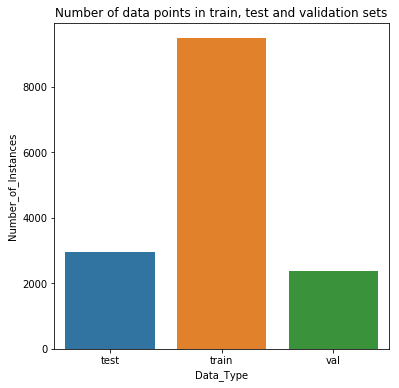

In [6]:
plt.figure(figsize=(6, 6))
plt.title ("Number of data points in train, test and validation sets")
sns.barplot(split_info['Data_Type'],split_info['Number_of_Instances'])
plt.show()

Here, we see that the dataset contains 9489 points for training set, 2373 points for test set and 2966 points for test set.

<h3> 3.5 Check for the distribution of data sources </h3>

In [27]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    data_source = pd.read_sql_query('SELECT synopsis_source as Data_Source, COUNT(*) AS Number_of_data_points FROM data GROUP BY synopsis_source', con)
    con.close()
    
data_source.head()

,Data_Source,Number_of_data_points
0,imdb,4172
1,wikipedia,10656


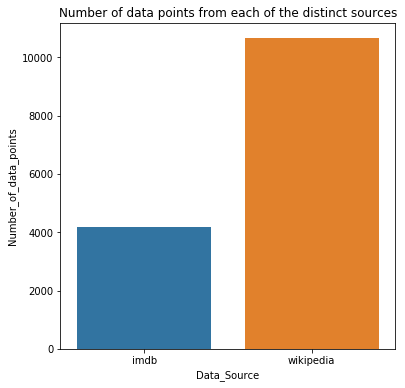

In [28]:
plt.figure(figsize=(6, 6))
plt.title ("Number of data points from each of the distinct sources")
sns.barplot(data_source['Data_Source'],data_source['Number_of_data_points'])
plt.show()

We can see that 4172 movie plots are taken from IMDB and 10656 movie plots are taken from Wikipedia.

<h3>3.6 Checking for duplicates entries in the dataset</h3>

In [29]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT title, plot_synopsis, tags, split, COUNT(*) as cnt_dup FROM data GROUP BY title, plot_synopsis, tags, split', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:00.473689


In [30]:
df_no_dup.head()

,title,plot_synopsis,tags,split,cnt_dup
0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,1
1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,1
2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,1
3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,1
4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,1


In [31]:
print("Number of rows in the original dataset: ",num_rows['count(*)'].values[0])
print("Number of rows in the de-duplicated dataset: ",df_no_dup.shape[0])

Number of rows in the original dataset:  14828
Number of rows in the de-duplicated dataset:  14781


In [32]:
print("Total number of duplicate entries removed from the given dataset: ",num_rows['count(*)'].values[0]-df_no_dup.shape[0])
print("Percentage of duplicate entries that were originally present: {} %".format(np.round((num_rows['count(*)'].values[0]-df_no_dup.shape[0])/num_rows['count(*)'].values[0]*100,2)))

Total number of duplicate entries removed from the given dataset:  47
Percentage of duplicate entries that were originally present: 0.32 %


<h3>3.7 Checking for the number of times each movie has appeared in the database </h3>

In [33]:
#Number of times each movie appeared in the database
#14743 movies occured only 1 time. 32 occurs 2 times. 4 movies occurs 3 times and 1 movie occurs 5 times
df_no_dup.cnt_dup.value_counts()

1    14743
2       32
3        4
5        1
4        1
Name: cnt_dup, dtype: int64

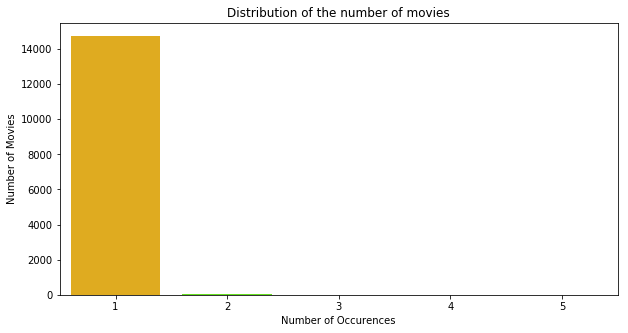

In [34]:
#Plot the rersult in a count plot
plt.figure(figsize=(10,5))
sns.countplot(df_no_dup.cnt_dup, palette='gist_rainbow')
plt.title("Distribution of the number of movies")
plt.xlabel("Number of Occurences")
plt.ylabel("Number of Movies")
plt.show()

<h3>3.8 Checking for the distribution of number of tags per movie. </h3>

In [35]:
#Here we will add a new feature called tags count, which will count the number of tags in each movie 
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["tags"].apply(lambda text: len(str(text).split(" ")))
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:00.024752


,title,plot_synopsis,tags,split,cnt_dup,tag_count
0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,1,1
1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,1,1
2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,1,5
3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,1,2
4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,1,7


In [36]:
#Distribution of number of tags per movie.
#5133 movies has 1 tag, 2990 has 2 tags, 1924 movies has 3 tags, 1318 movies has 4 tags and so on. There is one movie with 24 tags and 2 movies with 23tags.
df_no_dup.tag_count.value_counts()

1     5133
2     2990
3     1924
4     1318
5      960
6      661
7      492
8      374
9      252
10     191
11     136
12     100
13      70
14      44
15      35
16      31
17      21
18      18
20      11
19       8
21       3
26       2
27       2
22       2
23       2
24       1
Name: tag_count, dtype: int64

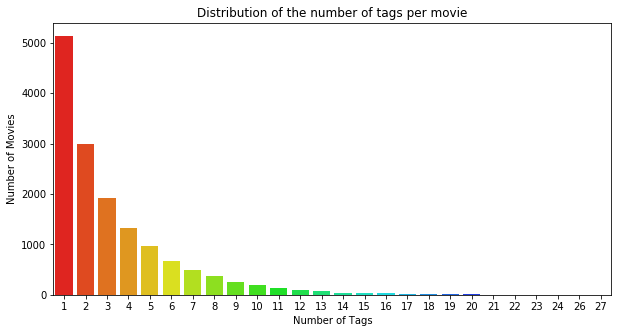

In [37]:
#Plot the rersult in a count plot
plt.figure(figsize=(10,5))
sns.countplot(df_no_dup.tag_count, palette='gist_rainbow')
plt.title("Distribution of the number of tags per movie")
plt.xlabel("Number of Tags")
plt.ylabel("Number of Movies")
plt.show()

### 4. Create a new database with no duplicate entries


In [38]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['title', 'plot_synopsis', 'tags', 'split'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [39]:
#This method seems more appropriate to work with this much data. Creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to generate train.db file")
    
tag_data.head()

Time taken to run this cell : 0:00:06.746424


,tags
1,flashback
2,"suspenseful, neo noir, murder, violence"
3,"cult, violence"
4,"murder, anti war, violence, flashback, tragedy..."
5,murder


<h3>Observations from the above analysis.</h3>

1. There were almost 0.32% movies which were duplicates. So the first thing we did, is remove the duplicate movies from the actual dataset and save it in a new dataset.
2. 14743 movies occurred only 1 time. 32 occurs 2 times. 4 movies occurs 3 times and 1 movie occurs 5 times
3. There are movies which contains just 1 tag and there are also movies which contains as many as 24 tags!

<h3>5. Analysis of Title Texts and Movie Plot Text</h3> 

In [4]:
#Load the de-duplicated dataset
start = datetime.now()
con = sqlite3.connect('train_no_dup.db')
dataframe = pd.read_sql_query("""SELECT * FROM no_dup_train""", con)
con.close()

dataframe.head()

,index,title,plot_synopsis,tags,split
0,0,$,"Set in Hamburg, West Germany, several criminal...",murder,test
1,1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train
2,2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train
3,3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train
4,4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train


In [22]:
#Printing some random movie plots from the deduplicated dataset.
sent_1 = dataframe['plot_synopsis'].values[0]
print(sent_1)
print("\nTags: {}".format(dataframe['tags'].values[0]))
print("="*215)

sent_2 = dataframe['plot_synopsis'].values[1000]
print(sent_2)
print("\nTags: {}".format(dataframe['tags'].values[1000]))
print("="*215)

sent_3 = dataframe['plot_synopsis'].values[1500]
print(sent_3)
print("\nTags: {}".format(dataframe['tags'].values[1500]))
print("="*215)

sent_4 = dataframe['plot_synopsis'].values[4900]
print(sent_4)
print("\nTags: {}".format(dataframe['tags'].values[4900]))
print("="*215)

Set in Hamburg, West Germany, several criminals take advantage of the German privacy bank laws to use safe deposit boxes in a German bank to store large amounts of illicit cash. These include a Las Vegas mobster known only as the Attorney (Robert Webber) as well as a ruthless drug smuggler known as the Candy Man (Arthur Brauss) and a crooked overbearing U.S. Army sergeant (Scott Brady) and his meek-mannered partner the Major (Robert Stiles), who conspire on a big heroin and LSD smuggling score. Joe Collins (Warren Beatty), an American bank security consultant, has been spying on them and makes mysterious and elaborate preparations to steal their money (totaling more than $1.5 million) with the help of Dawn Divine (Goldie Hawn), a hooker with a heart of gold.On the day of the robbery, Joe has Dawn phone in a bomb threat to the bank president, Mr. Kessel (Gert Fröbe), to create a diversion. Joe locks himself inside the bank vault with a gold bar normally displayed in the lobby to suppose

### 5.1 Getting a sense of the movie synopsis texts

In [23]:
#Utiliy functions for feature extraction
#Returns the count of 'http' elements present in a string. Return 0 otherwise.
def count_http(string):
    if string.__contains__("http"):
        return string.count("http")
    else:
        return int(0)

#Returns the number of times a reference link is present in a string
def count_href(string):
    if string.__contains__("a href"):
        return string.count("a href")
    else:
        return int(0)
    
#Number of times a greater than sign appears in a string    
def count_greater(string):
    if string.__contains__(">"):
        return string.count(">")
    else:
        return int(0)

In [24]:
#Simple feature engineering
basic_feats = pd.DataFrame()
basic_feats["Length_Title"] = dataframe['title'].apply(lambda x: len(str(x))) #Length of RAW Title text
basic_feats["Length_Plot_Synopsis"] = dataframe['plot_synopsis'].apply(lambda x: len(str(x))) #Length of RAW body text
basic_feats['count_plot_synopsis_http'] = dataframe['plot_synopsis'].apply(lambda x: count_http(str(x))) #Lazy way to count the number of URLs present in a body text. Not 100% accurate, but close enough
basic_feats['count_plot_synopsis_href'] = dataframe['plot_synopsis'].apply(lambda x: count_href(str(x))) #Lazy way to count the reference to an externel site. Not 100% accurate, but close enough
basic_feats['count_plot_synopsis_grtsign'] = dataframe['plot_synopsis'].apply(lambda x: count_greater(str(x))) #Very lazy way to count html tags present in a string. Not 100% accurate, but close enough

#Save the dataset containing basic features
basic_feats.to_csv('basic_feats.csv', columns=basic_feats.columns)
basic_feats.head(3)

,Length_Title,Length_Plot_Synopsis,count_plot_synopsis_http,count_plot_synopsis_href,count_plot_synopsis_grtsign
0,1,3657,0,0,0
1,7,2057,0,0,0
2,3,4193,0,0,0


In [25]:
basic_feats['count_plot_synopsis_grtsign'].value_counts()

0     14766
1         6
2         5
5         1
20        1
4         1
10        1
Name: count_plot_synopsis_grtsign, dtype: int64

<h3>5.2 High level statistics of the dataset containing simple features </h3> 

In [26]:
#Get a high level stats of the given dataset
basic_feats.describe()

,Length_Title,Length_Plot_Synopsis,count_plot_synopsis_http,count_plot_synopsis_href,count_plot_synopsis_grtsign
count,14781.000000,14781.000000,14781.000000,14781.0,14781.000000
mean,15.912658,5140.702118,0.000068,0.0,0.003721
std,8.502424,4945.551360,0.008225,0.0,0.195829
min,1.000000,442.000000,0.000000,0.0,0.000000
25%,10.000000,2491.000000,0.000000,0.0,0.000000
50%,14.000000,3825.000000,0.000000,0.0,0.000000
75%,20.000000,5760.000000,0.000000,0.0,0.000000
max,92.000000,63959.000000,1.000000,0.0,20.000000


In [27]:
#Get the percentage of movies which does not have a http referrence included in their body
zero = basic_feats[basic_feats['count_plot_synopsis_http'] == 0].shape[0]
per = (zero/basic_feats.shape[0]) * 100
print("Percentage of movie plots which does not have any http referrence URL in the body text: {:.2f}%".format(per))

#Get the percentage of questions which are provided with external reference links in their body text
zero = basic_feats[basic_feats['count_plot_synopsis_href'] == 0].shape[0]
per = (1-zero/basic_feats.shape[0]) * 100
print("Percentage of movie plots which does not have any external reference: {:.2f}%".format(per))

Percentage of movie plots which does not have any http referrence URL in the body text: 99.99%
Percentage of movie plots which does not have any external reference: 0.00%


### Observations from the above analysis:

1. A quick high level statistic revealed that the average length of movie plots is somewhere around 5140.
2. The maximum length of plot synopsis is as high as 63959 characters and the minimum length is 442 characters!
2. The average length of movie title is somewhere around 15
3. 92 is the maximum string length for a movie title and 1 is the minimum string length for a movie title.
4. 99.99% movie plots does not have any http reference in their body.
5. There are 20 movie plots which has the 'greater than' sign. 
6. Alsmost all the reviews has punctuation marks and contracted words in them.

<h3>3.1.8 Histograms of some of the extracted features</h3> 

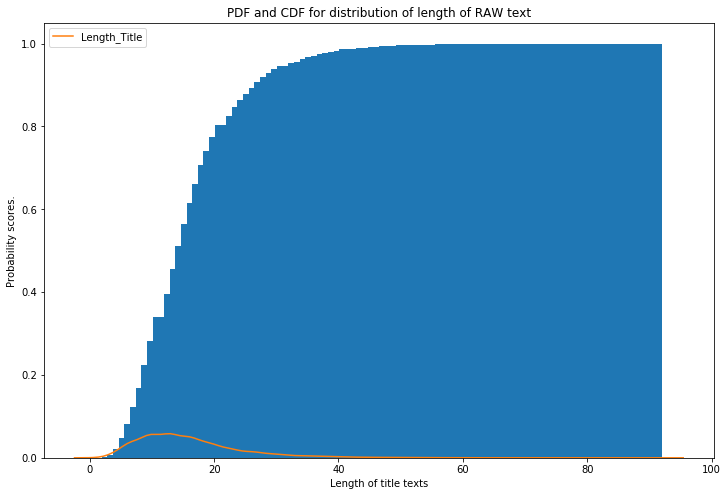

In [28]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer graphics

plt.figure(figsize=(12, 8))
myHist = plt.hist(basic_feats['Length_Title'].values, 100, density=True, cumulative=True)
plt.title('PDF and CDF for distribution of length of RAW text')
plt.xlabel('Length of title texts')
plt.ylabel('Probability scores.')
sns.kdeplot(basic_feats['Length_Title']);
plt.show()

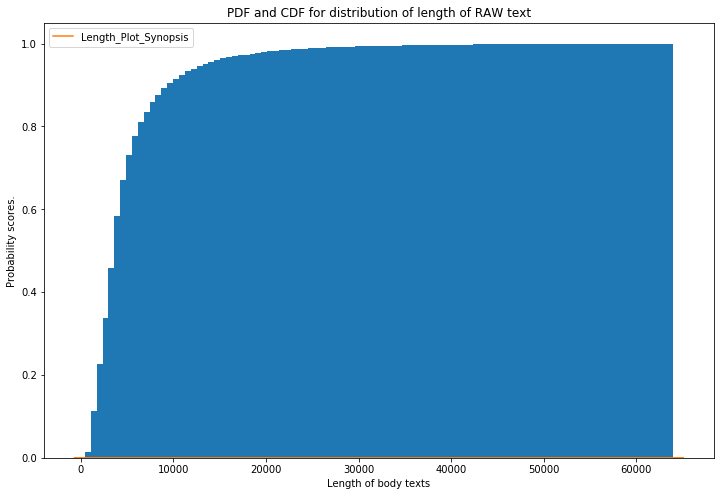

In [29]:
plt.figure(figsize=(12, 8))
myHist = plt.hist(basic_feats['Length_Plot_Synopsis'].values, 100, density=True, cumulative=True)
plt.title('PDF and CDF for distribution of length of RAW text')
plt.xlabel('Length of body texts')
plt.ylabel('Probability scores.')
sns.kdeplot(basic_feats['Length_Plot_Synopsis']);
plt.show()

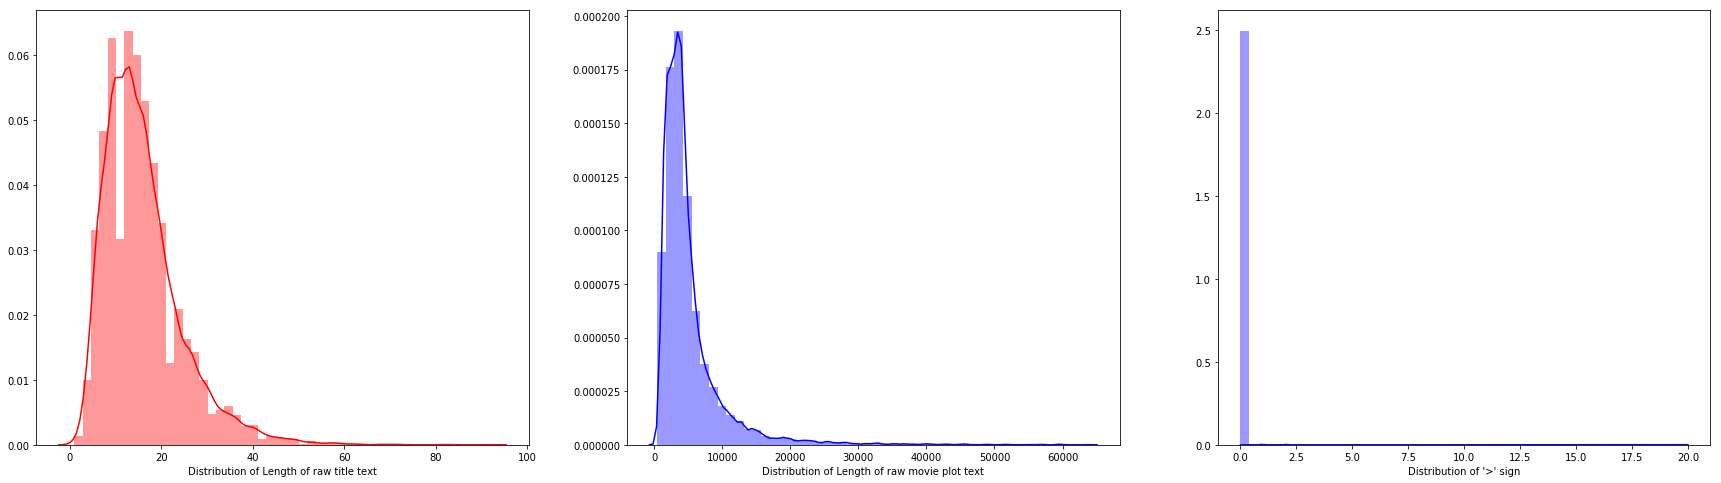

In [30]:
#Draw only PDF 
plt.figure(figsize=(30, 8))
plt.subplot(1,3,1)
sns.distplot([basic_feats['Length_Title']], color = 'red', axlabel="Distribution of Length of raw title text")
plt.subplot(1,3,2)
sns.distplot([basic_feats['Length_Plot_Synopsis']], color = 'blue', axlabel="Distribution of Length of raw movie plot text")
plt.subplot(1,3,3)
sns.distplot([basic_feats['count_plot_synopsis_grtsign']], color = 'blue', axlabel="Distribution of '>' sign")
plt.show()

### Observations:

1. We can see most of the title texts has median length around 15.
2. The median length of the plot synopsis is around 5000. The distribution of movie plot length is highly skewed towards the left.
3. There are very few movies which has plot synopsis length greater than 20000 characters.

<h2> 6. Analysis of Tags </h2>

<h3> 6.1 Total number of unique tags </h3>

In [6]:
#Importing & Initializing the "CountVectorizer" object, which is scikit-learn's bag of words tool. By default 'split()' will tokenize each tag using space.
def tokenize(x):
    x=x.split(',')
    tags=[i.strip() for i in x] #Some tags contains whitespaces before them, so we need to strip them
    return tags

vectorizer = CountVectorizer(tokenizer = tokenize)
tag_dtm = vectorizer.fit_transform(tag_data['tags'])

In [42]:
print("Number of movies present in the entire dataset :", tag_dtm.shape[0])
print("Number of unique tags present in the entire dataset:", tag_dtm.shape[1])

Number of movies present in the entire dataset : 14780
Number of unique tags present in the entire dataset: 71


In [43]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
print("Let's look at all the unique tags we have :\n\n", tags[:71])

Let's look at all the unique tags we have :

 ['absurd', 'action', 'adult comedy', 'allegory', 'alternate history', 'alternate reality', 'anti war', 'atmospheric', 'autobiographical', 'avant garde', 'blaxploitation', 'bleak', 'boring', 'brainwashing', 'christian film', 'claustrophobic', 'clever', 'comedy', 'comic', 'cruelty', 'cult', 'cute', 'dark', 'depressing', 'dramatic', 'entertaining', 'fantasy', 'feel-good', 'flashback', 'good versus evil', 'gothic', 'grindhouse film', 'haunting', 'historical', 'historical fiction', 'home movie', 'horror', 'humor', 'insanity', 'inspiring', 'intrigue', 'magical realism', 'melodrama', 'murder', 'mystery', 'neo noir', 'non fiction', 'paranormal', 'philosophical', 'plot twist', 'pornographic', 'prank', 'psychedelic', 'psychological', 'queer', 'realism', 'revenge', 'romantic', 'sadist', 'satire', 'sci-fi', 'sentimental', 'storytelling', 'stupid', 'suicidal', 'suspenseful', 'thought-provoking', 'tragedy', 'violence', 'western', 'whimsical']


<h3> 6.2 Number of times a tag appeared </h3>

In [44]:
#https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1 #axis=0 for columns. Column contain the number of times the tags have occured
result = dict(zip(tags, freqs))

In [46]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head(10)

,Tags,Counts
0,absurd,270
1,action,660
2,adult comedy,128
3,allegory,138
4,alternate history,102
5,alternate reality,205
6,anti war,118
7,atmospheric,396
8,autobiographical,44
9,avant garde,220


<h3> 6.3 Tags which are present the most number of times </h3>

In [47]:
#Sort the tags according to their number of occurences.
#We see that murder, violence, flashback, romantic, cult are the 5 most frequently occuring tags.
#We will visualize this distribtuion in a graph
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values
tag_df_sorted.head(10)

,Tags,Counts
43,murder,5771
68,violence,4423
28,flashback,2937
57,romantic,2900
20,cult,2647
56,revenge,2465
52,psychedelic,1897
17,comedy,1858
65,suspenseful,1086
29,good versus evil,875


In [48]:
#tag_counts contains how many times each tags appeared in the entire dataset
tag_counts

array([5771, 4423, 2937, 2900, 2647, 2465, 1897, 1858, 1086,  875,  822,
        815,  749,  745,  660,  652,  635,  591,  549,  546,  525,  519,
        485,  456,  442,  441,  412,  405,  396,  364,  309,  289,  272,
        270,  255,  233,  228,  220,  211,  205,  205,  205,  204,  197,
        190,  168,  163,  153,  150,  141,  138,  128,  120,  118,  118,
        114,  107,  102,   98,   87,   84,   79,   76,   74,   73,   66,
         54,   54,   44,   42,   37])

<h3>6.4 Analysis of Tags : Distribution of all tags, i.e the number of times each tag appeared in movie synopses.</h3>

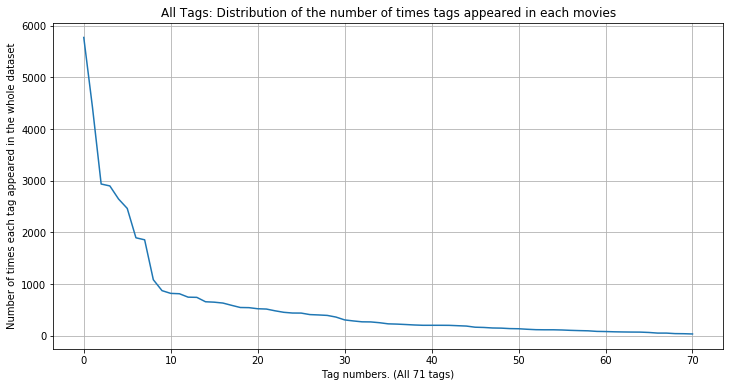

In [49]:
#Get the distribution information
plt.figure(figsize=(12, 6))
plt.plot(tag_counts)
plt.title("All Tags: Distribution of the number of times tags appeared in each movies")
plt.grid()
plt.xlabel("Tag numbers. (All 71 tags)")
plt.ylabel("Number of times each tag appeared in the whole dataset")
plt.show()

In [50]:
#Get a high level statistical view of the tags data
tag_df_sorted.describe()

,Counts
count,71.000000
mean,621.816901
std,1016.487149
min,37.000000
25%,119.000000
50%,233.000000
75%,570.000000
max,5771.000000


Text(0, 0.5, 'Number of Movies')

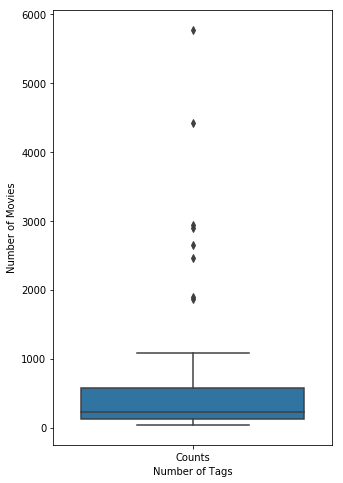

In [22]:
#Using boxplot plot to get a sense of the quantile values
plt.figure(figsize=(5, 8))
sns.boxplot(data = tag_df_sorted)
plt.xlabel("Number of Tags")
plt.ylabel("Number of Movies")

Key Observations:

1. 75% of tags occurs less than 570 times across different movies.
2. 25% of tags occurs less than 119 times across different movies.
3. The maximum number of times a tag occurs in a movie is 5771

In [35]:
#Store tags greater than 1K in one list
list_tags_grt_thn_1k = tag_df_sorted[tag_df_sorted.Counts>1000].Tags
#Print the length of the list
print ('{} Tags are used more than 1000 times'.format(len(list_tags_grt_thn_1k)))

# Store tags greater than 5K in one list
list_tags_grt_thn_5k = tag_df_sorted[tag_df_sorted.Counts>5000].Tags
#Print the length of the list.
print ('{} Tags are used more than 5000 times'.format(len(list_tags_grt_thn_5k)))

#Tags with the most frequency
print("Most frequently occuring tag: {}".format(tag_df_sorted.iloc[0][0]))
print("Number of times {} occurs: {}".format(tag_df_sorted.iloc[0][0],tag_counts[0]))

9 Tags are used more than 1000 times
1 Tags are used more than 5000 times
Most frequently occuring tag: murder
Number of times murder occurs: 5771


<b>Observations:</b><br />
1. There are total 9 tags which are used more than 1000 times.
2. 1 tags are used more than 5000 times.
3. Most frequent tag (i.e. 'murder') is used 5771 times.
4. Since some tags occur much more frequently than others, Micro-averaged F1-score is the appropriate metric for this problem.

<h3> 6.5 Tags Per Question </h3>

In [51]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()

#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:50])

We have total 14780 datapoints.
[1, 4, 2, 6, 1, 1, 2, 3, 1, 5, 1, 13, 1, 2, 1, 1, 15, 3, 1, 1, 2, 2, 2, 1, 5, 1, 1, 6, 11, 2, 3, 2, 4, 1, 4, 6, 3, 1, 5, 1, 5, 1, 1, 7, 7, 3, 1, 4, 4, 2]


In [52]:
print("Maximum number of tags per question: %d"%max(tag_quest_count))
print("Minimum number of tags per question: %d"%min(tag_quest_count))
print("Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 25
Minimum number of tags per question: 1
Avg. number of tags per question: 2.987077


In [75]:
#How many movies have tags less than or equal to 3?
tag_greater_than_avg_count = list(filter(lambda x: x<=3, tag_quest_count))
len(tag_greater_than_avg_count)

10551

In [77]:
#How many movies have tags less than or equal to 4?
tag_greater_than_avg_count = list(filter(lambda x: x<=4, tag_quest_count))
len(tag_greater_than_avg_count)

11789

In [78]:
#How many movies have tags less than or equal to 5?
tag_greater_than_avg_count = list(filter(lambda x: x<=5, tag_quest_count))
len(tag_greater_than_avg_count)

12705

In [79]:
#How many movies have tags less than or equal to 6?
tag_greater_than_avg_count = list(filter(lambda x: x<=6, tag_quest_count))
len(tag_greater_than_avg_count)

13311

<h3>6.6 Histogram for distribution of tags.</h3>

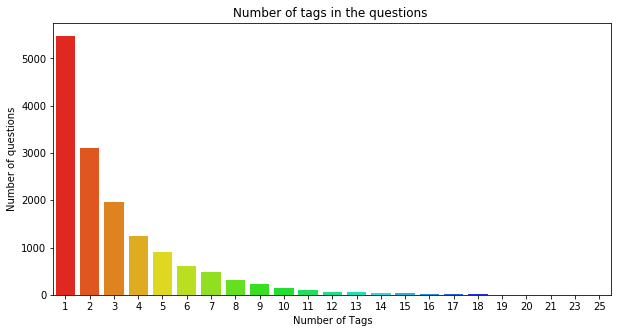

In [38]:
plt.figure(figsize=(10,5))
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the movies ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of movies")
plt.show()

<h3>Observations from the above analysis.</h3>

1. Maximum number of tags per movies: 25
2. Minimum number of tags per movies: 1
3. Avg. number of tags per question: 2.987077
4. Most of the movie plots has tags between 1 and 6. There are lesser number of movie synopses which has tags 7, 8, 9, 10, 11.
5. There are even lesser number of movies which has tags greater than 12, with the maximum number of tags going to as high as 25.

<h3>6.6 Word Cloud for the most frequently occurring tags in the movie synopses plots </h3>

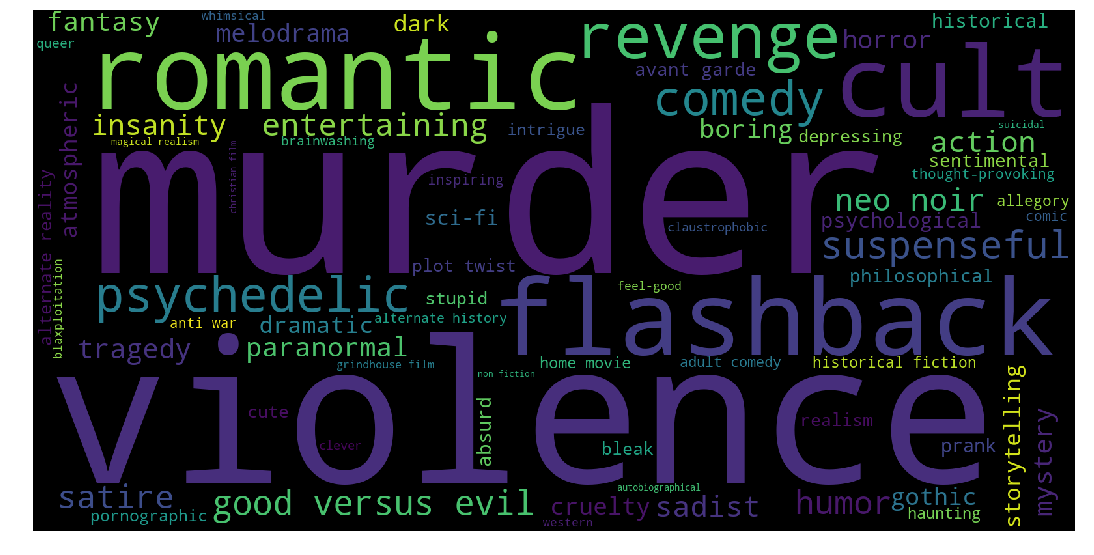

Time taken to run this cell : 0:00:02.301621


In [45]:
# Ploting word cloud
start = datetime.now()

#Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())

#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(background_color='black',width=1600,height=800,).generate_from_frequencies(tup)

fig = plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<h3>Observations from the above word cloud.</h3>

1. A look at the word cloud shows that "murder", "violence", flashback","romantic","cult" are the most frequently occurring tags in the movie synopses plots. 
2. There are lots of tags which occurs less frequently like "comedy","psychedelic","horror","entertaining","humor" etc.

<h3> 6.8 Distribution of frequently occurring tags by their frequency </h3>

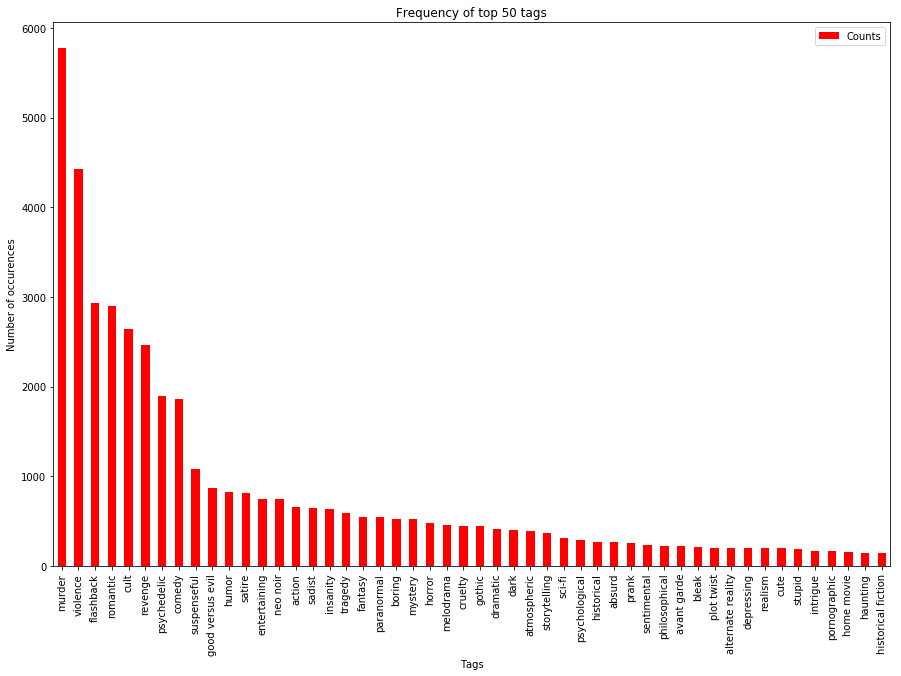

In [39]:
i=np.arange(50)
tag_df_sorted.head(50).plot(kind='bar', figsize=(15,10), rot=90, color='red')
plt.title('Frequency of top 50 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Number of occurences')
plt.show()

<h3>Observations from the above plot.</h3>

1. "Murder" is the most frequently occurring tags followed by "violence","flashback","romantic"
2. "Murder" and "Violence" occurs in more than 5000 movies. 
3. "Flashback","Romantic","Cult","Revenge" tags occurs in more than 2000 movies.
4. Almost all other remaining tags occurs less than 1000 number of times across the entire dataset. 

The above analysis is done on the entire dataset, later we will split the data into train and test data. We will use the train data and validation data for training and cross validating our model. We will use the test data for evaluating our models performance on unseen data.

<h3> 6.8 The least frequently occurring tags </h3>

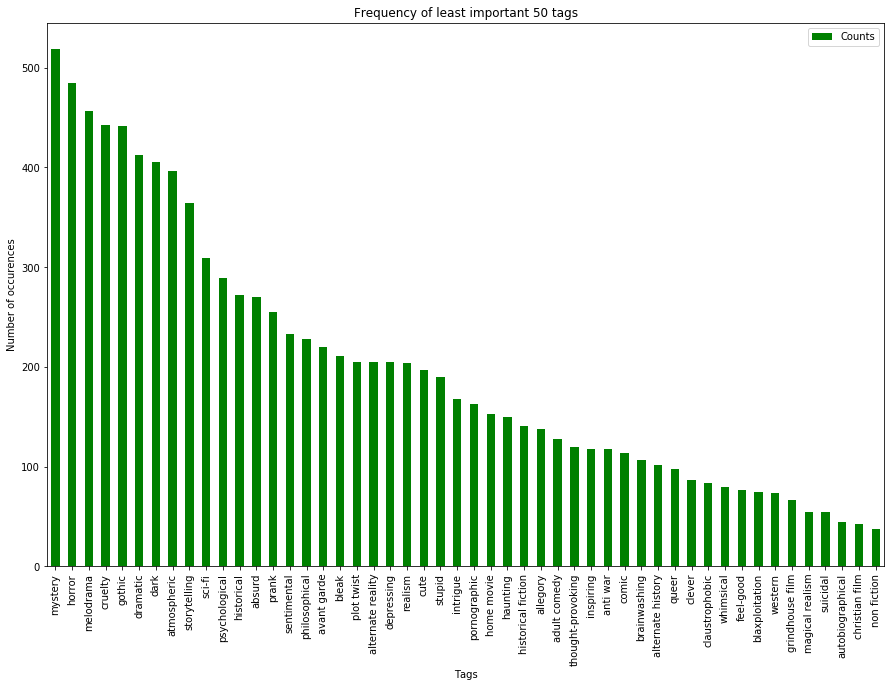

In [40]:
i=np.arange(50)
tag_df_sorted.tail(50).plot(kind='bar', figsize=(15,10), rot=90, color='green')
plt.title('Frequency of least important 50 tags')
plt.xticks(i, tag_df_sorted['Tags'][-50:])
plt.xlabel('Tags')
plt.ylabel('Number of occurences')
plt.show()

In [41]:
#These are the least frequently occuring tags
print("The tags which occurs least frequently across the entire dataset are: \n")
print(list(tag_df_sorted['Tags'][-50:]))

The tags which occurs least frequently across the entire dataset are: 

['mystery', 'horror', 'melodrama', 'cruelty', 'gothic', 'dramatic', 'dark', 'atmospheric', 'storytelling', 'sci-fi', 'psychological', 'historical', 'absurd', 'prank', 'sentimental', 'philosophical', 'avant garde', 'bleak', 'plot twist', 'alternate reality', 'depressing', 'realism', 'cute', 'stupid', 'intrigue', 'pornographic', 'home movie', 'haunting', 'historical fiction', 'allegory', 'adult comedy', 'thought-provoking', 'inspiring', 'anti war', 'comic', 'brainwashing', 'alternate history', 'queer', 'clever', 'claustrophobic', 'whimsical', 'feel-good', 'blaxploitation', 'western', 'grindhouse film', 'magical realism', 'suicidal', 'autobiographical', 'christian film', 'non fiction']


<h3> 6.9 EDA using K-Means Clustering on BOW representations of tags</h3> 

In [49]:
from sklearn.cluster import KMeans

#Elbow method to determine the best value of K in K-Means clustering.
def plot_elbow(sumOfSquaredErrors, n_clusters, vectorizationType):
    '''This function is used to plot the elbow curve for sum of squared errors vs cluster values and obtain the optimal 
    value of the hyperparameter K.'''
        
    k_values = n_clusters
    loss = sumOfSquaredErrors
    
    #Plot K_Values vs Loss Values
    plt.figure(figsize=(35,8))
    plt.plot(k_values,loss,color='red',linestyle='dashed',linewidth=5,marker='o',markerfacecolor='blue',markersize=10)
    for xy in zip(k_values, np.round(loss,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title('K vs Loss for {} model'.format(vectorizationType))
    plt.xlabel('Number of clusters')
    plt.ylabel('Loss (Sum of Squared Errors)')
    plt.show()
    
    optimal_k = input("Please select the optimal numberof clusters from the above elbow plot and press enter : ")
    print("The optimal number of clusters selected from the elbow method is {}".format(optimal_k))
    
    return optimal_k

#Function to perform KMeans Clustering.
def KMeansPlusPlus(tags_vectors):
    '''This function is used for multiple method calls which would determine the optimal value of k. The loss is calculated for each clusters and the value of the optimal 
    number of clusters is obtained by visualy examining the elbow plot. At the end the k-means algorithm will be run with the best value of K selected from the elbow plot'''
    t_start = datetime.now()
    sumOfSquaredErrors = []
    n_clusters = range(1,25)
    k_means = [KMeans(n_clusters=i, n_init=5, init='k-means++', n_jobs=8, random_state=0) for i in n_clusters] # algorithm = elkan for dense data data, default: algorithm = auto
    k_means_centroids = [k_mean.fit(tags_vectors) for k_mean in k_means]
    sumOfSquaredErrors = [k_mean.inertia_ for k_mean in k_means_centroids] # Inertia: Sum of distances of samples to their closest cluster center   
    optimal_k = int(plot_elbow(sumOfSquaredErrors, n_clusters, "BOW"))
    
    #Run k-medoids with the optimal number of clusters obtained from the elbow method
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', algorithm='auto', n_jobs=8, random_state=0).fit(tags_vectors)
    print("Time taken to perform K-Means clustering on Tags data: ",datetime.now() - t_start)
    
    return kmeans, optimal_k

#Function to draw word clouds for each clusters.
from wordcloud import WordCloud 
def word_clouds(kmeans_object, tags_corpus):
    #Labels of each data point
    labels=kmeans_object.labels_
    clusters_dict = {i: np.where(labels == i)[0] for i in range(optimal_k)}
    # Transform this dictionary into list (if you need a list as result)
    clusters_list = []
    print("The number of datapoints in each cluster are as follows : ")
    for key, value in clusters_dict.items():
        temp = [key,value]
        clusters_list.append(temp)
        print("Cluster = {}, Number of data points = {}".format(key+1,len(value)))

    from wordcloud import WordCloud    
    for cluster_number in range(optimal_k-2):
        cluster = [clusters_dict[cluster_number][i] for i in range(clusters_dict[cluster_number].size)]

        reviews_cluster = []
        for i in cluster: 
            reviews_cluster.append(tags_corpus[i])

        review_corpus = ""   
        for review in reviews_cluster:
            review_corpus = review_corpus + " " + review

        # lower max_font_size
        wordcloud = WordCloud(width=800, height=450, margin=2, prefer_horizontal=0.9, scale=1, max_words=75, 
                              min_font_size=4, random_state=42, background_color='black', 
                              contour_color='black', repeat=False).generate(str(review_corpus))
        plt.figure(figsize=(16,9))
        plt.title("Word Cloud for Cluster {}".format(cluster_number+1))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

In [42]:
tag_data.head()

,tags
1,flashback
2,"suspenseful, neo noir, murder, violence"
3,"cult, violence"
4,"murder, anti war, violence, flashback, tragedy..."
5,murder


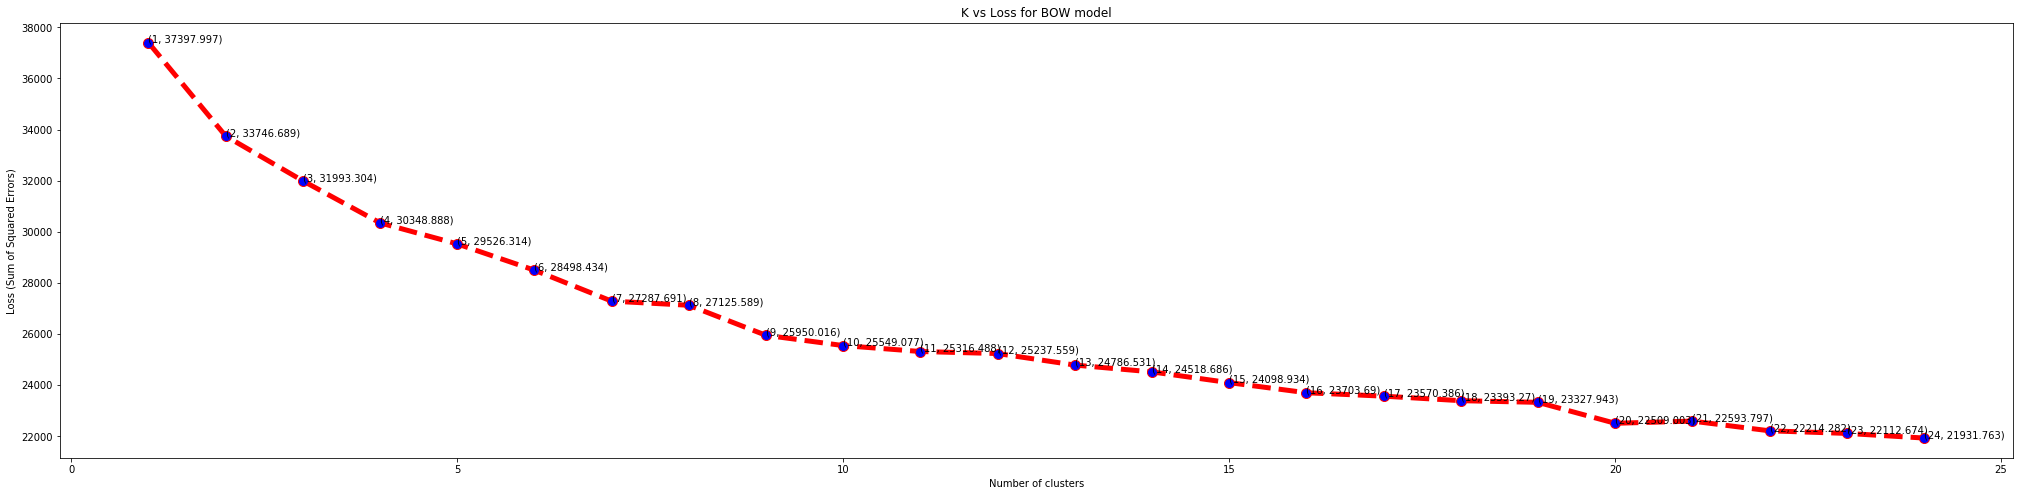

Please select the optimal numberof clusters from the above elbow plot and press enter : 7
The optimal number of clusters selected from the elbow method is 7
Time taken to perform K-Means clustering on Tags data:  0:04:52.614027


In [100]:
#Taking all the tags
tags_corpus=tag_data['tags'].apply(lambda x: str(x)) #Avoid encoding problems
cv_object = CountVectorizer(tokenizer = tokenize).fit(tags_corpus) #Initializing the BOW constructor
tags_vectors = cv_object.transform(tags_corpus) #Creating BOW vectors of all the tags
kmeans_object, optimal_k = KMeansPlusPlus(tags_vectors) #KMeans++ Algorithm function call to get the best kmeans object and optimal number of clusters

The number of datapoints in each cluster are as follows : 
Cluster = 1, Number of data points = 5060
Cluster = 2, Number of data points = 2114
Cluster = 3, Number of data points = 1194
Cluster = 4, Number of data points = 1756
Cluster = 5, Number of data points = 1049
Cluster = 6, Number of data points = 1787
Cluster = 7, Number of data points = 1820


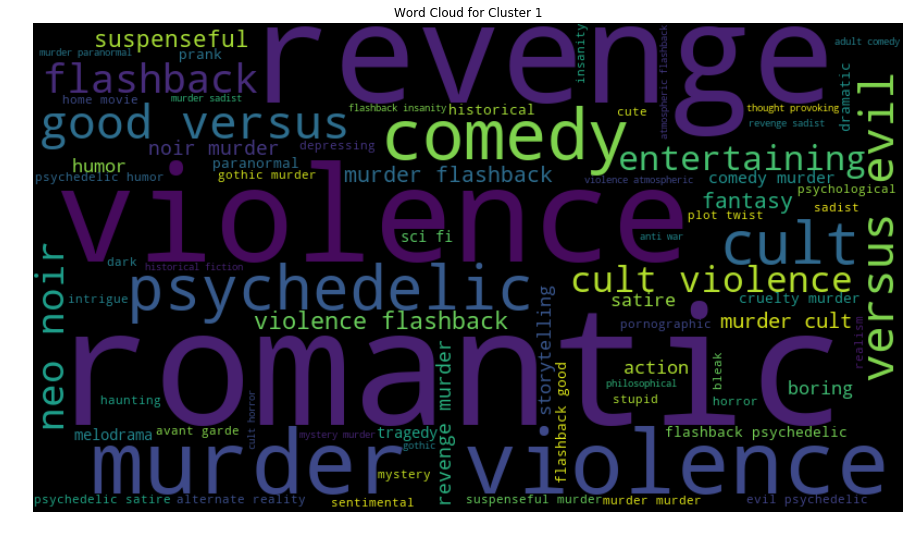

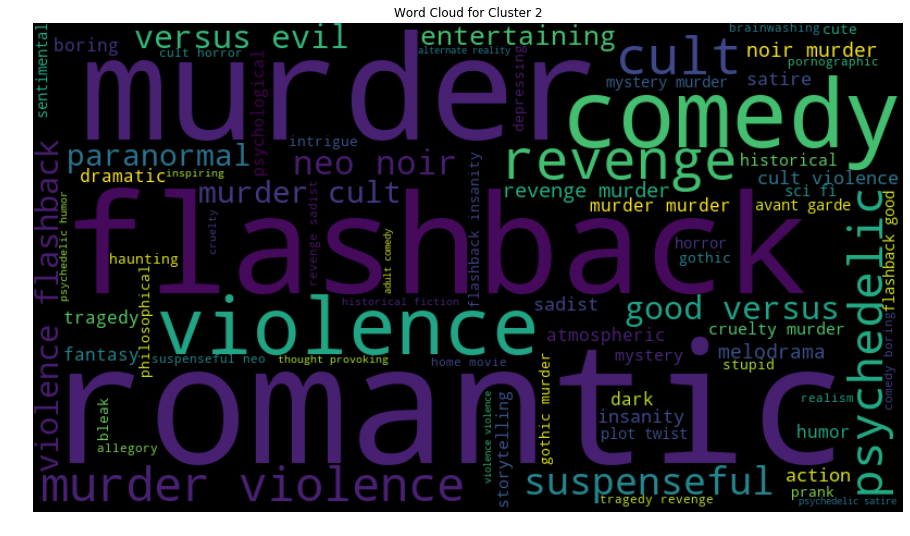

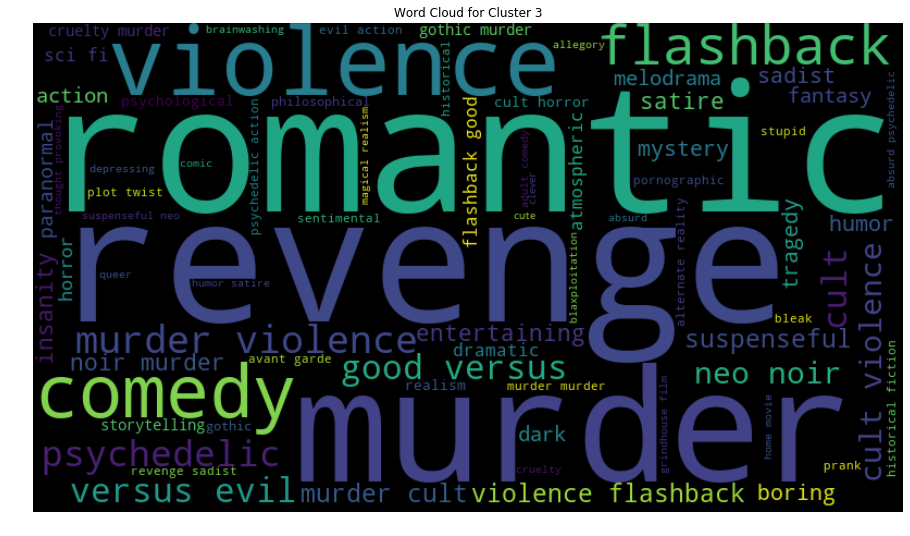

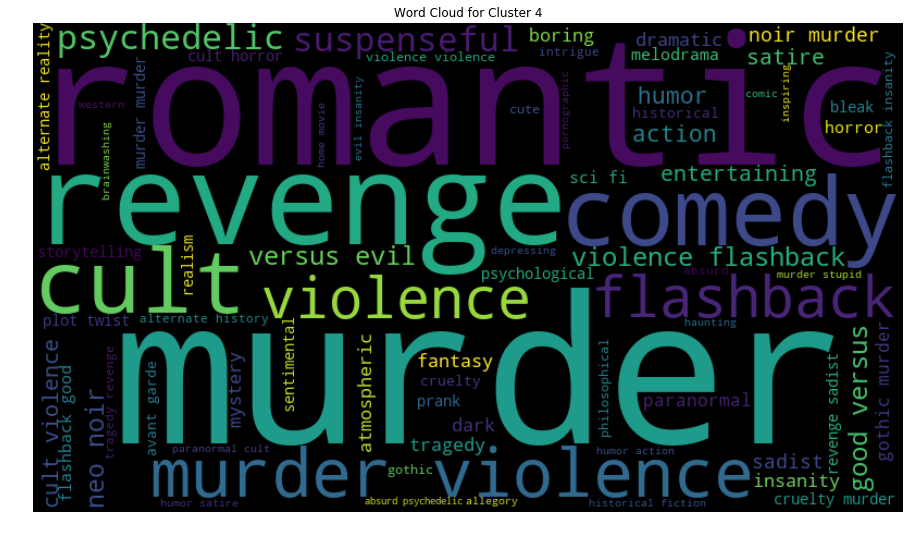

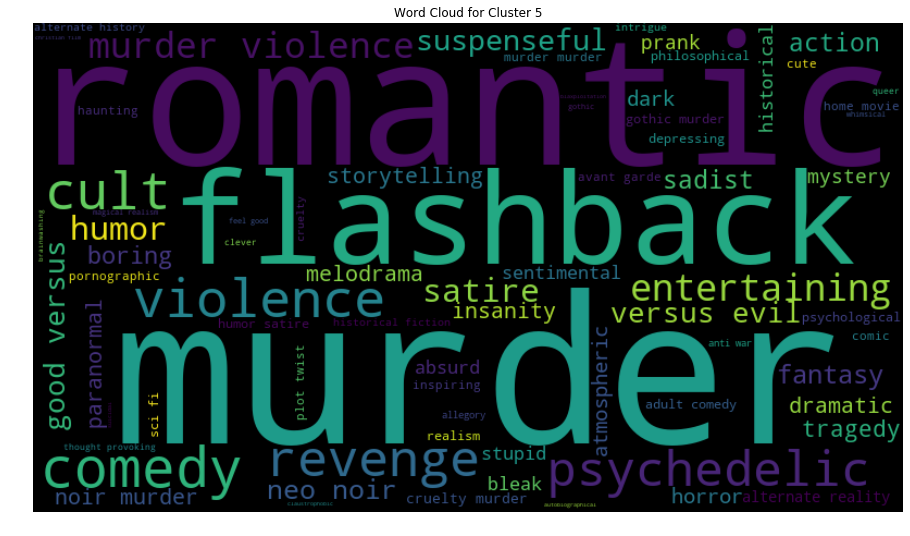

In [107]:
#Plot word clouds of similar tags
word_clouds(kmeans_object, tags_corpus)

## Analysis from the tags clusters.

1. In all the 5 clusters we see that the tags "violence","murder" has a tendency to occur together. 
2. We can also see tags like "revenge" which has a tendency to occur with tags like both "murder" and "romantic".
3. Tags like "cult", "evil", "violence" has a higher chance of occurring together. 
4. Tags like "comedy","melodrama" and "entertaining" has a higher chance of occurring together.
5. "Psychedelic", "Suspenseful" and "boring" has higher chances of occurring together.

<h2> 7. Cleaning and preprocessing of Movie plot synopsis </h2>

1. We will remove the html tags (if any) from the movie plots
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Perform decontraction of words
8. Finally Snowball Stemming the word (it was observed to be better than Porter Stemming)

In [43]:
#Load the de-duplicated dataset
start = datetime.now()
con = sqlite3.connect('train_no_dup.db')
dataframe = pd.read_sql_query("""SELECT * FROM no_dup_train""", con)
con.close()

dataframe.head()

,index,title,plot_synopsis,tags,split
0,0,$,"Set in Hamburg, West Germany, several criminal...",murder,test
1,1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train
2,2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train
3,3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train
4,4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train


#### Print the original movie plots

In [51]:
#Printing some random movie plots from the deduplicated dataset.
sent_1 = dataframe['plot_synopsis'].values[0]
print(sent_1)
print("\nTags: {}".format(dataframe['tags'].values[0]))
print("="*215)

sent_2 = dataframe['plot_synopsis'].values[1000]
print(sent_2)
print("\nTags: {}".format(dataframe['tags'].values[1000]))
print("="*215)

sent_3 = dataframe['plot_synopsis'].values[1500]
print(sent_3)
print("\nTags: {}".format(dataframe['tags'].values[1500]))
print("="*215)

sent_4 = dataframe['plot_synopsis'].values[4900]
print(sent_4)
print("\nTags: {}".format(dataframe['tags'].values[4900]))
print("="*215)

Set in Hamburg, West Germany, several criminals take advantage of the German privacy bank laws to use safe deposit boxes in a German bank to store large amounts of illicit cash. These include a Las Vegas mobster known only as the Attorney (Robert Webber) as well as a ruthless drug smuggler known as the Candy Man (Arthur Brauss) and a crooked overbearing U.S. Army sergeant (Scott Brady) and his meek-mannered partner the Major (Robert Stiles), who conspire on a big heroin and LSD smuggling score. Joe Collins (Warren Beatty), an American bank security consultant, has been spying on them and makes mysterious and elaborate preparations to steal their money (totaling more than $1.5 million) with the help of Dawn Divine (Goldie Hawn), a hooker with a heart of gold.On the day of the robbery, Joe has Dawn phone in a bomb threat to the bank president, Mr. Kessel (Gert Fröbe), to create a diversion. Joe locks himself inside the bank vault with a gold bar normally displayed in the lobby to suppose

#### Print the movie plots after removing URLS (if any)

In [52]:
#Remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_1 = re.sub(r"http\S+", " ", sent_1)
sent_2 = re.sub(r"http\S+", " ", sent_2)
sent_3 = re.sub(r"http\S+", " ", sent_3)
sent_4 = re.sub(r"http\S+", " ", sent_4)

print(sent_1 + "\n")
print(sent_2 + "\n")
print(sent_3 + "\n")
print(sent_4 + "\n")

Set in Hamburg, West Germany, several criminals take advantage of the German privacy bank laws to use safe deposit boxes in a German bank to store large amounts of illicit cash. These include a Las Vegas mobster known only as the Attorney (Robert Webber) as well as a ruthless drug smuggler known as the Candy Man (Arthur Brauss) and a crooked overbearing U.S. Army sergeant (Scott Brady) and his meek-mannered partner the Major (Robert Stiles), who conspire on a big heroin and LSD smuggling score. Joe Collins (Warren Beatty), an American bank security consultant, has been spying on them and makes mysterious and elaborate preparations to steal their money (totaling more than $1.5 million) with the help of Dawn Divine (Goldie Hawn), a hooker with a heart of gold.On the day of the robbery, Joe has Dawn phone in a bomb threat to the bank president, Mr. Kessel (Gert Fröbe), to create a diversion. Joe locks himself inside the bank vault with a gold bar normally displayed in the lobby to suppose

#### Print the movie plots after removing HTML tags (if any)

In [53]:
#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text


print(removeHtml(sent_1) + "\n")
print(removeHtml(sent_2) + "\n")
print(removeHtml(sent_3) + "\n")
print(removeHtml(sent_4) + "\n")

Set in Hamburg, West Germany, several criminals take advantage of the German privacy bank laws to use safe deposit boxes in a German bank to store large amounts of illicit cash. These include a Las Vegas mobster known only as the Attorney (Robert Webber) as well as a ruthless drug smuggler known as the Candy Man (Arthur Brauss) and a crooked overbearing U.S. Army sergeant (Scott Brady) and his meek-mannered partner the Major (Robert Stiles), who conspire on a big heroin and LSD smuggling score. Joe Collins (Warren Beatty), an American bank security consultant, has been spying on them and makes mysterious and elaborate preparations to steal their money (totaling more than $1.5 million) with the help of Dawn Divine (Goldie Hawn), a hooker with a heart of gold.On the day of the robbery, Joe has Dawn phone in a bomb threat to the bank president, Mr. Kessel (Gert Fröbe), to create a diversion. Joe locks himself inside the bank vault with a gold bar normally displayed in the lobby to suppose

#### Print the movie plots after de-contracting the movies

In [54]:
# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
import re

#Expand the movie plots x is an input string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

print(decontracted(sent_1) + "\n")
print(decontracted(sent_2) + "\n")
print(decontracted(sent_3) + "\n")
print(decontracted(sent_4) + "\n")

set in hamburg, west germany, several criminals take advantage of the german privacy bank laws to use safe deposit boxes in a german bank to store large amounts of illicit cash. these include a las vegas mobster known only as the attorney (robert webber) as well as a ruthless drug smuggler known as the candy man (arthur brauss) and a crooked overbearing u.s. army sergeant (scott brady) and his meek-mannered partner the major (robert stiles), who conspire on a big heroin and lsd smuggling score. joe collins (warren beatty), an american bank security consultant, has been spying on them and makes mysterious and elaborate preparations to steal their money (totaling more than  dollar 1.5 million) with the help of dawn divine (goldie hawn), a hooker with a heart of gold.on the day of the robbery, joe has dawn phone in a bomb threat to the bank president, mr. kessel (gert fröbe), to create a diversion. joe locks himself inside the bank vault with a gold bar normally displayed in the lobby to 

#### Remove words with numbers

In [55]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
'''
>>> import re
>>> s = "ABCD abcd AB55 55CD A55D 5555"
>>> re.sub("\S*\d\S*", "", s).strip()

'ABCD abcd'
>>>'''

sent_1 = re.sub("\S*\d\S*", " ", sent_1).strip()
print(sent_1 +"\n")

sent_2 = re.sub("\S*\d\S*", " ", sent_2).strip()
print(sent_2 +"\n")

sent_3 = re.sub("\S*\d\S*", " ", sent_3).strip()
print(sent_3 +"\n")

sent_4 = re.sub("\S*\d\S*", " ", sent_4).strip()
print(sent_4 +"\n")

Set in Hamburg, West Germany, several criminals take advantage of the German privacy bank laws to use safe deposit boxes in a German bank to store large amounts of illicit cash. These include a Las Vegas mobster known only as the Attorney (Robert Webber) as well as a ruthless drug smuggler known as the Candy Man (Arthur Brauss) and a crooked overbearing U.S. Army sergeant (Scott Brady) and his meek-mannered partner the Major (Robert Stiles), who conspire on a big heroin and LSD smuggling score. Joe Collins (Warren Beatty), an American bank security consultant, has been spying on them and makes mysterious and elaborate preparations to steal their money (totaling more than   million) with the help of Dawn Divine (Goldie Hawn), a hooker with a heart of gold.On the day of the robbery, Joe has Dawn phone in a bomb threat to the bank president, Mr. Kessel (Gert Fröbe), to create a diversion. Joe locks himself inside the bank vault with a gold bar normally displayed in the lobby to supposedly

#### Utility functions to clean the movie synopses

In [2]:
#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)
    
#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc. https://stackoverflow.com/a/5843547/4084039
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)


#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['no', 'nor', 'not'])
custom_stopwords = default_stopwords - remove_not

print(custom_stopwords)

{'mustn', 'themselves', 'haven', 'himself', 'any', 'each', 'if', 'here', 'ours', "won't", 'a', 'on', 'its', 'where', 'they', 'at', 'hasn', 'so', 'shan', 'we', 'when', "you'll", 'his', "she's", 'me', "that'll", 'about', 'their', "hadn't", 'wasn', 'weren', 'the', 'why', 'didn', 'herself', 'out', 'your', 'yours', 'does', "doesn't", 'what', 'be', 'all', 't', 'yourselves', 'hadn', "wasn't", 'through', 'aren', 'ma', 'is', 'them', 'once', 'will', "didn't", 'while', 's', "aren't", 'of', 'up', 'further', 'wouldn', 'that', 'below', 'him', 'just', 'my', 'did', 'were', 'until', 'over', 'few', 'an', 'having', 'but', 'off', "you've", 'only', 'y', 'how', 'then', 'doesn', 'doing', 'into', 'yourself', "mightn't", 'more', 'this', 'from', "shouldn't", 'can', 'myself', "you'd", 'those', 'in', 'was', 'll', 'whom', 'to', "mustn't", "haven't", 'do', 'these', 'o', 'have', 'needn', 'after', 'our', 'too', "you're", "isn't", "needn't", "don't", 'been', 'i', 'other', 'during', 'd', 'between', "weren't", 'ourselve

In [57]:
# Combining all the above data cleaning methodologies as discussed above.
string=' '    
stemed_word=' '

preprocessed_movie_plots =[]

for movie_plot in tqdm(dataframe['plot_synopsis'].values):
    filtered_sentence=[]
    movie_plot = decontracted(movie_plot)
    movie_plot = removeNumbers(movie_plot)
    movie_plot = removeHtml(movie_plot)
    movie_plot = removeURL(movie_plot)
    movie_plot = removePunctuations(movie_plot)
    movie_plot = removePatterns(movie_plot)
    
    for cleaned_words in movie_plot.split():   
        if((cleaned_words not in custom_stopwords) and (len(cleaned_words)>2)):
            stemed_word=(sno.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
        else:
            continue
    movie_plot = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_movie_plots.append(movie_plot.strip()) #Data corpus contaning cleaned movie_plots from the whole dataset
    
#Adding a column of CleanedPlots to the table final which stores the data_corpus after pre-processing the movie_plots 
dataframe['CleanedPlots']=preprocessed_movie_plots 
    
print("The length of the data corpus is : {}".format(len(preprocessed_movie_plots)))

dataframe.head()

100%|██████████| 14781/14781 [03:33<00:00, 69.10it/s]

The length of the data corpus is : 14781


,index,title,plot_synopsis,tags,split,CleanedPlots
0,0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,set hamburg west germani sever crimin take adv...
1,1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,grader name griffin bing decid gather entir gr...
2,2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,gari hook new recruit british armi take leav m...
3,3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,sergeant dragon jacki chan part hong kong mari...
4,4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,pretoria south africa major charl bolton rod m...


In [6]:
#Data cleaning without stemming for use with word vectors

preprocessed_movie_plots =[]

for movie_plot in tqdm(dataframe['plot_synopsis'].values):
    filtered_sentence=[]
    movie_plot = decontracted(movie_plot)
    movie_plot = removeNumbers(movie_plot)
    movie_plot = removeHtml(movie_plot)
    movie_plot = removeURL(movie_plot)
    movie_plot = removePunctuations(movie_plot)
    movie_plot = removePatterns(movie_plot)
    
    for cleaned_words in movie_plot.split():   
        if((cleaned_words not in custom_stopwords) and (len(cleaned_words)>2)):
            word=cleaned_words.lower()                                  
            filtered_sentence.append(word)
        else:
            continue
    movie_plot = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_movie_plots.append(movie_plot.strip()) #Data corpus contaning cleaned movie_plots from the whole dataset
    
#Adding a column of CleanedPlots to the table final which stores the data_corpus after pre-processing the movie_plots 
dataframe['CleanedPlots_NoStemming']=preprocessed_movie_plots 
    
print("The length of the data corpus is : {}".format(len(preprocessed_movie_plots)))

dataframe.head()

100%|██████████| 14781/14781 [00:56<00:00, 259.53it/s]

The length of the data corpus is : 14781


,index,title,plot_synopsis,tags,split,CleanedPlots,CleanedPlots_NoStemming
0,0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,set hamburg west germani sever crimin take adv...,set hamburg west germany several criminals tak...
1,1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,grader name griffin bing decid gather entir gr...,grader named griffin bing decides gather entir...
2,2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,gari hook new recruit british armi take leav m...,gary hook new recruit british army takes leave...
3,3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,sergeant dragon jacki chan part hong kong mari...,sergeant dragon jackie chan part hong kong mar...
4,4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,pretoria south africa major charl bolton rod m...,pretoria south africa major charles bolton rod...


### We will create a new dataset to store the cleaned movie plot synopses

In [7]:
dataframe.to_csv("cleaned_movie_plots.csv", index=False)

In [8]:
print("Number of data points in sample :", dataframe.shape[0])
print("Number of dimensions :", dataframe.shape[1])

Number of data points in sample : 14781
Number of dimensions : 7


<h1>8. Machine Learning Models with OneVsRest</h1>

<h2> 8.1 Splitting the dataset into train and test </h2>

Here, since we will perform random search cross validation, we will take the "train" and "validation" data mentioned in the "split" column as our total training data. 

In [3]:
#Load the processed dataset
dataframe=pd.read_csv("cleaned_movie_plots.csv")
dataframe.head()

,index,title,plot_synopsis,tags,split,CleanedPlots,CleanedPlots_NoStemming
0,0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,set hamburg west germani sever crimin take adv...,set hamburg west germany several criminals tak...
1,1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,grader name griffin bing decid gather entir gr...,grader named griffin bing decides gather entir...
2,2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,gari hook new recruit british armi take leav m...,gary hook new recruit british army takes leave...
3,3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,sergeant dragon jacki chan part hong kong mari...,sergeant dragon jackie chan part hong kong mar...
4,4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,pretoria south africa major charl bolton rod m...,pretoria south africa major charles bolton rod...


In [4]:
#Create a dataset for train and test
data_test=dataframe.loc[(dataframe['split'] == 'test')]
data_train=dataframe.loc[(dataframe['split'] == 'val') | (dataframe['split'] == 'train')]

#Split the whole data into train and test set
X_train = data_train['CleanedPlots']
y_train = data_train['tags']

X_test = data_test['CleanedPlots']
y_test = data_test['tags']

print("Number of points in training data: ",data_train.shape[0])
print("Number of points in test data: ",data_test.shape[0])

Number of points in training data:  11816
Number of points in test data:  2965


### Convert the tags to binary vectors for multi label classification

<table>
<tr>
<th>X</th><th>t1</th><th>t2</th><th>t3</th><th>t4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [8]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true').fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

In [9]:
y_train_multilabel

<11816x71 sparse matrix of type '<class 'numpy.int64'>'
	with 35129 stored elements in Compressed Sparse Row format>

In [10]:
y_test_multilabel

<2965x71 sparse matrix of type '<class 'numpy.int64'>'
	with 9021 stored elements in Compressed Sparse Row format>

<h2>8.2 Featurizing data with TF-IDF vectorizer (1-Grams)</h2>

In [10]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,1))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:04.556160


In [11]:
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (11816, 39462) Y : (11816, 71)
Dimensions of test data X: (2965, 39462) Y: (2965, 71)


<h2> 8.2.1 Applying Logistic Regression with OneVsRest Classifier </h2>

In [72]:
from sklearn.linear_model import LogisticRegression
start = datetime.now()

classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l1', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.01821247892074199
Hamming loss  0.08066883594993231

Micro-average quality numbers
Precision: 0.2542, Recall: 0.4562, F1-measure: 0.3264

Macro-average quality numbers
Precision: 0.1250, Recall: 0.2475, F1-measure: 0.1635

Classification Report
              precision    recall  f1-score   support

           0       0.07      0.14      0.09        56
           1       0.19      0.42      0.26       129
           2       0.08      0.18      0.11        28
           3       0.05      0.09      0.06        22
           4       0.19      0.61      0.29        18
           5       0.04      0.11      0.06        35
           6       0.19      0.40      0.26        30
           7       0.06      0.14      0.08        79
           8       0.00      0.00      0.00         8
           9       0.08      0.18      0.11        45
          10       0.12      0.27      0.16        11
          11       0.03      0.07      0.04        40
          12       0.07      0.15      

/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [73]:
joblib.dump(classifier1, 'ovr_with_lr_clf1.pkl') 

['ovr_with_lr_clf1.pkl']

<h2> 8.2.2 Applying Logistic Regression with OneVsRest Classifier + SGDClassifier </h2>

In [74]:
start = datetime.now()

classifier2 = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1', class_weight='balanced'), n_jobs=-1)
classifier2.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier2.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.0030354131534569982
Hamming loss  0.13473624207301144

Micro-average quality numbers
Precision: 0.1577, Recall: 0.4937, F1-measure: 0.2390

Macro-average quality numbers
Precision: 0.0936, Recall: 0.3335, F1-measure: 0.1325

Classification Report
              precision    recall  f1-score   support

           0       0.03      0.14      0.05        56
           1       0.13      0.43      0.20       129
           2       0.04      0.39      0.07        28
           3       0.01      0.14      0.02        22
           4       0.04      0.61      0.08        18
           5       0.04      0.31      0.07        35
           6       0.06      0.40      0.10        30
           7       0.05      0.25      0.09        79
           8       0.01      0.25      0.01         8
           9       0.03      0.18      0.06        45
          10       0.03      0.64      0.05        11
          11       0.03      0.20      0.05        40
          12       0.06      0.23    

/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [75]:
from sklearn.externals import joblib
joblib.dump(classifier2, 'ovr_with_lr_sgd_clf2.pkl') 

['ovr_with_lr_sgd_clf2.pkl']

<h2> 8.2.3 Applying Linear SVM with OneVsRest Classifier + SGDClassifier with 'hinge' loss </h2>

In [100]:
start = datetime.now()

classifier2 = OneVsRestClassifier(SGDClassifier(loss='hinge',penalty='l1', class_weight='balanced'), n_jobs=-1)
classifier2.fit(X_train_multilabel, y_train_multilabel) 
predictions = classifier2.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.003372681281618887
Hamming loss  0.1436572215756597

Micro-average quality numbers
Precision: 0.1437, Recall: 0.4744, F1-measure: 0.2206

Macro-average quality numbers
Precision: 0.0897, Recall: 0.3445, F1-measure: 0.1272

Classification Report
              precision    recall  f1-score   support

           0       0.04      0.25      0.06        56
           1       0.14      0.46      0.21       129
           2       0.03      0.29      0.06        28
           3       0.02      0.23      0.03        22
           4       0.04      0.50      0.07        18
           5       0.01      0.14      0.03        35
           6       0.05      0.50      0.09        30
           7       0.04      0.25      0.07        79
           8       0.01      0.25      0.02         8
           9       0.04      0.27      0.06        45
          10       0.02      0.45      0.03        11
          11       0.02      0.17      0.04        40
          12       0.05      0.21      

In [101]:
from sklearn.externals import joblib
joblib.dump(classifier2, 'ovr_with_svm_sgd_clf2.pkl') 

['ovr_with_svm_sgd_clf2.pkl']

<h2> 8.3 Featurizing data with TfIdf vectorizer (1-2 Grams) </h2>

In [104]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:29.360189


In [105]:
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (11816, 718424) Y : (11816, 71)
Dimensions of test data X: (2965, 718424) Y: (2965, 71)


<h2> 8.3.1 Applying Logistic Regression with OneVsRest Classifier </h2>

In [82]:
start = datetime.now()

classifier3 = OneVsRestClassifier(LogisticRegression(penalty='l1', class_weight='balanced'), n_jobs=-1)
classifier3.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier3.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.017537942664418212
Hamming loss  0.08845925468493931

Micro-average quality numbers
Precision: 0.2387, Recall: 0.4863, F1-measure: 0.3203

Macro-average quality numbers
Precision: 0.1207, Recall: 0.2776, F1-measure: 0.1647

Classification Report
              precision    recall  f1-score   support

           0       0.06      0.16      0.09        56
           1       0.18      0.47      0.25       129
           2       0.07      0.18      0.10        28
           3       0.04      0.09      0.06        22
           4       0.17      0.61      0.27        18
           5       0.05      0.17      0.07        35
           6       0.12      0.33      0.18        30
           7       0.05      0.16      0.08        79
           8       0.00      0.00      0.00         8
           9       0.10      0.27      0.15        45
          10       0.14      0.36      0.21        11
          11       0.03      0.10      0.05        40
          12       0.07      0.17     

In [83]:
joblib.dump(classifier3, 'ovr_with_lr_clf3_bigrams.pkl') 

['ovr_with_lr_clf3_bigrams.pkl']

<h2> 8.3.2 Applying Logistic Regression with OneVsRest Classifier + SGDClassifier</h2>

In [85]:
start = datetime.now()

classifier4 = OneVsRestClassifier(SGDClassifier(loss='log',penalty='l1', class_weight='balanced'), n_jobs=-1)
classifier4.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier4.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.004721753794266442
Hamming loss  0.136170819181531

Micro-average quality numbers
Precision: 0.1608, Recall: 0.5160, F1-measure: 0.2452

Macro-average quality numbers
Precision: 0.0952, Recall: 0.3537, F1-measure: 0.1371

Classification Report
              precision    recall  f1-score   support

           0       0.02      0.14      0.04        56
           1       0.17      0.49      0.25       129
           2       0.03      0.29      0.05        28
           3       0.01      0.09      0.02        22
           4       0.04      0.56      0.08        18
           5       0.03      0.31      0.06        35
           6       0.06      0.53      0.11        30
           7       0.05      0.27      0.09        79
           8       0.01      0.25      0.01         8
           9       0.04      0.27      0.07        45
          10       0.02      0.36      0.04        11
          11       0.02      0.15      0.03        40
          12       0.06      0.23      0

In [88]:
joblib.dump(classifier4, 'ovr_with_sgd_clf4_bigrams.pkl') 

['ovr_with_sgd_clf4_bigrams.pkl']

<h2> 8.3.3 Applying Linear SVM with OneVsRest Classifier + SGDClassifier with 'hinge' loss </h2>

In [106]:
start = datetime.now()

classifier3 = OneVsRestClassifier(SGDClassifier(loss='hinge',penalty='l1', class_weight='balanced'), n_jobs=-1)
classifier3.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier3.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.0030354131534569982
Hamming loss  0.14862598864688978

Micro-average quality numbers
Precision: 0.1476, Recall: 0.5169, F1-measure: 0.2296

Macro-average quality numbers
Precision: 0.0916, Recall: 0.3802, F1-measure: 0.1326

Classification Report
              precision    recall  f1-score   support

           0       0.04      0.27      0.07        56
           1       0.14      0.55      0.23       129
           2       0.03      0.32      0.06        28
           3       0.01      0.18      0.02        22
           4       0.04      0.72      0.08        18
           5       0.05      0.46      0.09        35
           6       0.05      0.50      0.09        30
           7       0.06      0.32      0.10        79
           8       0.01      0.62      0.03         8
           9       0.05      0.33      0.08        45
          10       0.02      0.36      0.04        11
          11       0.03      0.20      0.05        40
          12       0.05      0.27    

In [107]:
from sklearn.externals import joblib
joblib.dump(classifier3, 'ovr_with_svm_sgd_clf3.pkl') 

['ovr_with_svm_sgd_clf3.pkl']

<h2> 8.4 Featurizing data with TfIdf vectorizer (1-3 Grams) </h2>

In [108]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:03.432895


In [109]:
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (11816, 100000) Y : (11816, 71)
Dimensions of test data X: (2965, 100000) Y: (2965, 71)


<h2> 8.4.1 Applying Logistic Regression with OneVsRest Classifier </h2>

In [91]:
start = datetime.now()

classifier5 = OneVsRestClassifier(LogisticRegression(penalty='l1', class_weight='balanced'), n_jobs=-1)
classifier5.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier5.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.017200674536256323
Hamming loss  0.08469705246657008

Micro-average quality numbers
Precision: 0.2457, Recall: 0.4719, F1-measure: 0.3232

Macro-average quality numbers
Precision: 0.1222, Recall: 0.2618, F1-measure: 0.1636

Classification Report
              precision    recall  f1-score   support

           0       0.06      0.14      0.08        56
           1       0.18      0.45      0.26       129
           2       0.07      0.18      0.10        28
           3       0.04      0.09      0.06        22
           4       0.18      0.61      0.27        18
           5       0.05      0.14      0.07        35
           6       0.15      0.37      0.22        30
           7       0.07      0.19      0.10        79
           8       0.00      0.00      0.00         8
           9       0.08      0.18      0.11        45
          10       0.15      0.36      0.21        11
          11       0.03      0.07      0.04        40
          12       0.07      0.17     

In [92]:
joblib.dump(classifier5, 'ovr_with_lr_clf5_3ngrams.pkl') 

['ovr_with_lr_clf5_3ngrams.pkl']

<h2> 8.4.2 Applying Linear SVM with OneVsRest Classifier + SGDClassifier with 'hinge' loss </h2>

In [110]:
start = datetime.now()

classifier5 = OneVsRestClassifier(SGDClassifier(loss='hinge',penalty='l1', class_weight='balanced'), n_jobs=-1)
classifier5.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier5.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.002360876897133221
Hamming loss  0.14654537681400376

Micro-average quality numbers
Precision: 0.1465, Recall: 0.5014, F1-measure: 0.2267

Macro-average quality numbers
Precision: 0.0908, Recall: 0.3610, F1-measure: 0.1303

Classification Report
              precision    recall  f1-score   support

           0       0.04      0.25      0.07        56
           1       0.12      0.43      0.18       129
           2       0.03      0.29      0.05        28
           3       0.01      0.18      0.03        22
           4       0.04      0.67      0.08        18
           5       0.02      0.20      0.03        35
           6       0.05      0.43      0.08        30
           7       0.05      0.28      0.09        79
           8       0.01      0.25      0.01         8
           9       0.04      0.31      0.07        45
          10       0.02      0.45      0.03        11
          11       0.01      0.12      0.03        40
          12       0.06      0.29     

In [111]:
from sklearn.externals import joblib
joblib.dump(classifier5, 'ovr_with_svm_sgd_clf5.pkl') 

['ovr_with_svm_sgd_clf5.pkl']

<h2> 8.5 Featurizing data with TfIdf vectorizer (1-4 Grams) </h2>

In [112]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:39.370960


In [113]:
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (11816, 100000) Y : (11816, 71)
Dimensions of test data X: (2965, 100000) Y: (2965, 71)


<h2> 8.5.1 Applying Logistic Regression with OneVsRest Classifier </h2>

In [95]:
start = datetime.now()

classifier6 = OneVsRestClassifier(LogisticRegression(penalty='l1', class_weight='balanced'), n_jobs=-1)
classifier6.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier6.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.01821247892074199
Hamming loss  0.0846020473600456

Micro-average quality numbers
Precision: 0.2462, Recall: 0.4725, F1-measure: 0.3237

Macro-average quality numbers
Precision: 0.1229, Recall: 0.2630, F1-measure: 0.1645

Classification Report
              precision    recall  f1-score   support

           0       0.06      0.14      0.08        56
           1       0.18      0.45      0.26       129
           2       0.07      0.18      0.10        28
           3       0.05      0.09      0.06        22
           4       0.18      0.61      0.27        18
           5       0.05      0.14      0.07        35
           6       0.15      0.37      0.21        30
           7       0.07      0.19      0.10        79
           8       0.00      0.00      0.00         8
           9       0.08      0.18      0.11        45
          10       0.15      0.36      0.21        11
          11       0.03      0.07      0.04        40
          12       0.07      0.17      0

In [96]:
joblib.dump(classifier6, 'ovr_with_lr_clf6_4ngrams.pkl') 

['ovr_with_lr_clf6_4ngrams.pkl']

<h2> 8.5.2 Applying Linear SVM with OneVsRest Classifier + SGDClassifier with 'hinge' loss </h2>

In [114]:
start = datetime.now()

classifier6 = OneVsRestClassifier(SGDClassifier(loss='hinge',penalty='l1', class_weight='balanced'), n_jobs=-1)
classifier6.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier6.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.003372681281618887
Hamming loss  0.14492553974776146

Micro-average quality numbers
Precision: 0.1466, Recall: 0.4938, F1-measure: 0.2260

Macro-average quality numbers
Precision: 0.0910, Recall: 0.3605, F1-measure: 0.1301

Classification Report
              precision    recall  f1-score   support

           0       0.02      0.14      0.04        56
           1       0.15      0.53      0.24       129
           2       0.04      0.36      0.06        28
           3       0.02      0.23      0.03        22
           4       0.03      0.61      0.06        18
           5       0.02      0.23      0.04        35
           6       0.06      0.57      0.10        30
           7       0.05      0.25      0.08        79
           8       0.01      0.38      0.01         8
           9       0.03      0.20      0.05        45
          10       0.02      0.45      0.04        11
          11       0.03      0.28      0.06        40
          12       0.06      0.24     

In [115]:
from sklearn.externals import joblib
joblib.dump(classifier6, 'ovr_with_svm_sgd_clf6.pkl') 

['ovr_with_svm_sgd_clf6.pkl']

### Observation:

As we can see till now, the LogisticRegression Classifier gave us a much better Micro F1 score than the rest of the classifiers. So, we will proceed to hyperparameter tune the classifiers now to see if we can obtain a better F1 score.

<h2> 9. Hyperparameter tuning section with Logistic Regression and OneVsRest</h2>

Because, we have observed that Logistic Regression gave us a better Micro-F1 score than SVMs

### 9.1.1 TFIDF with (1-1 Grams)

In [11]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,1))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

#Convert the tags to binary vectors using sklearns count vectorizer
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true').fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:04.839401


### 9.1.2 Get best estimator using RandomSearch + Logistic Regression

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py

Time taken to perform hyperparameter tuning:  0:52:50.367842
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.3177680376911081


### 9.1.3 Fit the best estimator on the data

In [13]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, 'lr_ovr_tfidf_hyp_tuned_1gram.pkl') 

Accuracy : 0.01821247892074199
Hamming loss  0.08066408569460609

Micro-average quality numbers
Precision: 0.2542, Recall: 0.4562, F1-measure: 0.3264

Macro-average quality numbers
Precision: 0.1250, Recall: 0.2475, F1-measure: 0.1635

Classification Report
              precision    recall  f1-score   support

           0       0.07      0.14      0.09        56
           1       0.19      0.42      0.26       129
           2       0.08      0.18      0.11        28
           3       0.05      0.09      0.06        22
           4       0.19      0.61      0.29        18
           5       0.04      0.11      0.06        35
           6       0.19      0.40      0.26        30
           7       0.06      0.14      0.08        79
           8       0.00      0.00      0.00         8
           9       0.08      0.18      0.11        45
          10       0.12      0.27      0.16        11
          11       0.03      0.07      0.04        40
          12       0.07      0.15      

/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


['lr_ovr_tfidf_hyp_tuned_1gram.pkl']

### 9.2.1 TFIDF with (1-2 Grams)

In [14]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

#Convert the tags to binary vectors using sklearns count vectorizer
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true').fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:28.094092


### 9.2.2 Get best estimator using RandomSearch + Logistic Regression

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py

Time taken to perform hyperparameter tuning:  0:36:31.161965
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.35738148298544803


### 9.2.3 Fit the best estimator on the data

In [17]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, 'lr_ovr_tfidf_hyp_tuned_1_2.pkl') 

Accuracy : 0.044856661045531196
Hamming loss  0.06280312566800465

Micro-average quality numbers
Precision: 0.3220, Recall: 0.4212, F1-measure: 0.3650

Macro-average quality numbers
Precision: 0.1672, Recall: 0.2130, F1-measure: 0.1833

Classification Report
              precision    recall  f1-score   support

           0       0.12      0.09      0.10        56
           1       0.20      0.39      0.27       129
           2       0.19      0.18      0.18        28
           3       0.16      0.14      0.15        22
           4       0.32      0.50      0.39        18
           5       0.08      0.09      0.08        35
           6       0.26      0.30      0.28        30
           7       0.10      0.15      0.12        79
           8       0.00      0.00      0.00         8
           9       0.10      0.09      0.09        45
          10       0.30      0.27      0.29        11
          11       0.03      0.03      0.03        40
          12       0.10      0.13     

/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


['lr_ovr_tfidf_hyp_tuned_1_2.pkl']

### 9.3.1 TFIDF with (1-3 Grams)

In [10]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=50000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

#Convert the tags to binary vectors using sklearns count vectorizer
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true').fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:02.372571


### 9.3.2 Get best estimator using RandomSearch + Logistic Regression

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:28:20.873867
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.35414796078745714


### 9.3.3 Fit the best estimator on the data

In [12]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, 'lr_ovr_tfidf_hyp_tuned_1_3.pkl') 

Accuracy : 0.0387858347386172
Hamming loss  0.06511174975654942

Micro-average quality numbers
Precision: 0.3122, Recall: 0.4319, F1-measure: 0.3624

Macro-average quality numbers
Precision: 0.1628, Recall: 0.2256, F1-measure: 0.1857

Classification Report
              precision    recall  f1-score   support

           0       0.11      0.09      0.10        56
           1       0.19      0.40      0.26       129
           2       0.17      0.18      0.17        28
           3       0.14      0.14      0.14        22
           4       0.30      0.56      0.39        18
           5       0.09      0.11      0.10        35
           6       0.24      0.30      0.26        30
           7       0.09      0.16      0.12        79
           8       0.00      0.00      0.00         8
           9       0.10      0.11      0.11        45
          10       0.23      0.27      0.25        11
          11       0.03      0.03      0.03        40
          12       0.10      0.15      0

['lr_ovr_tfidf_hyp_tuned_1_3.pkl']

### 9.4.1 TFIDF with (1-4 Grams)

In [13]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=50000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

#Convert the tags to binary vectors using sklearns count vectorizer
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true').fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:37.292444


### 9.4.2 Get best estimator using RandomSearch + Logistic Regression

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:34:45.812867
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.3400063205214817


### 9.4.3 Fit the best estimator on the data

In [15]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, 'lr_ovr_tfidf_hyp_tuned_1_4.pkl') 

Accuracy : 0.023608768971332208
Hamming loss  0.08311996769826378

Micro-average quality numbers
Precision: 0.2569, Recall: 0.4965, F1-measure: 0.3386

Macro-average quality numbers
Precision: 0.1412, Recall: 0.2902, F1-measure: 0.1853

Classification Report
              precision    recall  f1-score   support

           0       0.07      0.11      0.09        56
           1       0.17      0.51      0.26       129
           2       0.11      0.18      0.14        28
           3       0.08      0.14      0.10        22
           4       0.22      0.61      0.32        18
           5       0.05      0.14      0.08        35
           6       0.14      0.37      0.20        30
           7       0.08      0.28      0.12        79
           8       0.00      0.00      0.00         8
           9       0.11      0.18      0.13        45
          10       0.20      0.27      0.23        11
          11       0.04      0.10      0.06        40
          12       0.08      0.23     

['lr_ovr_tfidf_hyp_tuned_1_4.pkl']

### 10. Taking average number of tags for each movie plots ~ 3

In the EDA section of analysis of tags, we have seen that there are almost 10500 movies which has tags less than or equal to 3.

In [12]:
#Take the maximum number of tags equal to the average number of tags as seen in the EDA section. Average number = 3
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true', max_features=3).fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

### 10.1.1 Vectorize the plot synopsis using TFIDF Unigrams

In [14]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,1))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:04.360477


### 10.1.2 Get best estimator using RandomSearch + Logistic Regression

In [80]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:08:43.547991
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=16.13975444638871, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5160388863197276


### 10.1.3 Fit the best estimator on the data

In [82]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '3_tags_unigram.pkl') 

Accuracy : 0.3730185497470489
Hamming loss  0.29803260258572234

Micro-average quality numbers
Precision: 0.5021, Recall: 0.5045, F1-measure: 0.5033

Macro-average quality numbers
Precision: 0.4687, Recall: 0.4706, F1-measure: 0.4696

Classification Report
              precision    recall  f1-score   support

           0       0.28      0.28      0.28       596
           1       0.59      0.59      0.59      1155
           2       0.54      0.54      0.54       911

   micro avg       0.50      0.50      0.50      2662
   macro avg       0.47      0.47      0.47      2662
weighted avg       0.50      0.50      0.50      2662
 samples avg       0.30      0.29      0.28      2662

Time taken to run this cell : 0:00:07.637160


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


['3_tags_unigram.pkl']

### 10.2.1 Vectorize the plot synopsis using TFIDF Bigrams

In [83]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(2,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:23.583663


### 10.2.2 Get best estimator using RandomSearch + Logistic Regression

In [87]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:01:41.747636
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=210.29664510876157, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.4952942597033721


### 10.2.3 Fit the best estimator on the data

In [86]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '3_tags_bigram.pkl') 

Accuracy : 0.4357504215851602
Hamming loss  0.25362563237774033

Micro-average quality numbers
Precision: 0.5978, Recall: 0.4662, F1-measure: 0.5238

Macro-average quality numbers
Precision: 0.5483, Recall: 0.4233, F1-measure: 0.4713

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.18      0.25       596
           1       0.65      0.58      0.61      1155
           2       0.61      0.50      0.55       911

   micro avg       0.60      0.47      0.52      2662
   macro avg       0.55      0.42      0.47      2662
weighted avg       0.58      0.47      0.51      2662
 samples avg       0.29      0.26      0.26      2662

Time taken to run this cell : 0:00:02.977072


['3_tags_bigram.pkl']

### 10.3.1 Vectorize the plot synopsis using TFIDF Trigrams

In [88]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(3,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:34.491495


### 10.3.2 Get best estimator using RandomSearch + Logistic Regression

In [89]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:00:40.892219
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=776.6363836807939, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.3947535754694917


### 10.3.3 Fit the best estimator on the data

In [91]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '3_tags_trigram.pkl') 

Accuracy : 0.31770657672849917
Hamming loss  0.33265879707700957

Micro-average quality numbers
Precision: 0.4394, Recall: 0.4046, F1-measure: 0.4213

Macro-average quality numbers
Precision: 0.4013, Recall: 0.3707, F1-measure: 0.3851

Classification Report
              precision    recall  f1-score   support

           0       0.23      0.19      0.21       596
           1       0.53      0.51      0.52      1155
           2       0.45      0.41      0.43       911

   micro avg       0.44      0.40      0.42      2662
   macro avg       0.40      0.37      0.39      2662
weighted avg       0.43      0.40      0.42      2662
 samples avg       0.25      0.24      0.23      2662

Time taken to run this cell : 0:00:01.938548


['3_tags_trigram.pkl']

### 10.4.1 Vectorize the plot synopsis using TFIDF 4grams

In [92]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(4,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:35.692424


### 10.4.2 Get best estimator using RandomSearch + Logistic Regression

In [93]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:00:34.408051
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=987.2532318059303, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.28436249765698424


### 10.4.3 Fit the best estimator on the data

In [94]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '3_tags_quadgram.pkl') 

Accuracy : 0.36930860033726814
Hamming loss  0.32344013490725126

Micro-average quality numbers
Precision: 0.3947, Recall: 0.1514, F1-measure: 0.2188

Macro-average quality numbers
Precision: 0.3813, Recall: 0.1454, F1-measure: 0.2097

Classification Report
              precision    recall  f1-score   support

           0       0.23      0.11      0.15       596
           1       0.49      0.17      0.25      1155
           2       0.43      0.16      0.23       911

   micro avg       0.39      0.15      0.22      2662
   macro avg       0.38      0.15      0.21      2662
weighted avg       0.41      0.15      0.22      2662
 samples avg       0.08      0.09      0.08      2662

Time taken to run this cell : 0:00:01.620718


['3_tags_quadgram.pkl']

### 10.5.1 Vectorize the plot synopsis using TFIDF Ngrams (1,2)

In [95]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:29.006345


### 10.5.2 Get best estimator using RandomSearch + Logistic Regression

In [96]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:06:16.684811
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=160.98270917946266, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5264291037887373


### 10.5.3 Fit the best estimator on the data

In [97]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '3_tags_ngrams12.pkl') 

Accuracy : 0.39494097807757167
Hamming loss  0.2848791455874087

Micro-average quality numbers
Precision: 0.5253, Recall: 0.4996, F1-measure: 0.5121

Macro-average quality numbers
Precision: 0.4847, Recall: 0.4611, F1-measure: 0.4722

Classification Report
              precision    recall  f1-score   support

           0       0.29      0.25      0.27       596
           1       0.60      0.61      0.60      1155
           2       0.57      0.53      0.55       911

   micro avg       0.53      0.50      0.51      2662
   macro avg       0.48      0.46      0.47      2662
weighted avg       0.52      0.50      0.51      2662
 samples avg       0.30      0.29      0.28      2662

Time taken to run this cell : 0:00:06.312505


['3_tags_ngrams12.pkl']

### 10.6.1 Vectorize the plot synopsis using TFIDF Ngrams (1,3)

In [98]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:02.880278


### 10.6.2 Get best estimator using RandomSearch + Logistic Regression

In [99]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:07:36.723844
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=116.8546229723123, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5279890472817385


### 10.6.3 Fit the best estimator on the data

In [100]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '3_tags_ngrams13.pkl') 

Accuracy : 0.396964586846543
Hamming loss  0.28454187745924675

Micro-average quality numbers
Precision: 0.5258, Recall: 0.5015, F1-measure: 0.5134

Macro-average quality numbers
Precision: 0.4856, Recall: 0.4632, F1-measure: 0.4738

Classification Report
              precision    recall  f1-score   support

           0       0.29      0.25      0.27       596
           1       0.60      0.61      0.60      1155
           2       0.57      0.53      0.55       911

   micro avg       0.53      0.50      0.51      2662
   macro avg       0.49      0.46      0.47      2662
weighted avg       0.52      0.50      0.51      2662
 samples avg       0.30      0.29      0.28      2662

Time taken to run this cell : 0:00:06.153483


['3_tags_ngrams13.pkl']

### 10.7.1 Vectorize the plot synopsis using TFIDF Ngrams (1,4)

In [102]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:37.173883


### 10.7.2 Get best estimator using RandomSearch + Logistic Regression

In [103]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:07:34.542658
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=233.72196849516303, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.525654372835437


### 10.7.3 Fit the best estimator on the data

In [105]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '3_tags_ngrams14.pkl') 

Accuracy : 0.393929173693086
Hamming loss  0.28566610455311975

Micro-average quality numbers
Precision: 0.5238, Recall: 0.5000, F1-measure: 0.5116

Macro-average quality numbers
Precision: 0.4837, Recall: 0.4617, F1-measure: 0.4721

Classification Report
              precision    recall  f1-score   support

           0       0.28      0.25      0.27       596
           1       0.60      0.61      0.60      1155
           2       0.57      0.53      0.55       911

   micro avg       0.52      0.50      0.51      2662
   macro avg       0.48      0.46      0.47      2662
weighted avg       0.52      0.50      0.51      2662
 samples avg       0.30      0.29      0.28      2662

Time taken to run this cell : 0:00:07.822810


['3_tags_ngrams14.pkl']

In [106]:
##Check

### 11. Taking average number of tags for each movie plots ~ 4

In the EDA section of analysis of tags, we have seen that there are almost 11500 movies which has tags less than or equal to 4.

In [110]:
#Take the maximum number of tags equal to the average number of tags as seen in the EDA section. Average number = 4
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true', max_features=4).fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

### 11.1.1 Vectorize the plot synopsis using TFIDF Unigrams

In [111]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,1))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:04.547426


### 11.1.2 Get best estimator using RandomSearch + Logistic Regression

In [112]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:07:55.441729
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1.7402759372625587, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5540249072690279


### 11.1.3 Fit the best estimator on the data

In [113]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '4_tags_unigram.pkl') 

Accuracy : 0.29106239460371
Hamming loss  0.27436762225969646

Micro-average quality numbers
Precision: 0.4994, Recall: 0.6202, F1-measure: 0.5533

Macro-average quality numbers
Precision: 0.4785, Recall: 0.5963, F1-measure: 0.5294

Classification Report
              precision    recall  f1-score   support

           0       0.31      0.44      0.36       596
           1       0.64      0.69      0.66      1155
           2       0.42      0.58      0.49       587
           3       0.55      0.68      0.60       911

   micro avg       0.50      0.62      0.55      3249
   macro avg       0.48      0.60      0.53      3249
weighted avg       0.51      0.62      0.56      3249
 samples avg       0.40      0.44      0.39      3249

Time taken to run this cell : 0:00:01.634362


['4_tags_unigram.pkl']

### 11.2.1 Vectorize the plot synopsis using TFIDF Bigrams

In [114]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(2,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:22.595376


### 11.2.2 Get best estimator using RandomSearch + Logistic Regression

In [115]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:02:28.628601
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=12.42955151524594, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.48719459337968507


### 11.2.3 Fit the best estimator on the data

In [116]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '4_tags_bigram.pkl') 

Accuracy : 0.3399662731871838
Hamming loss  0.24139966273187183

Micro-average quality numbers
Precision: 0.5739, Recall: 0.4611, F1-measure: 0.5114

Macro-average quality numbers
Precision: 0.5298, Recall: 0.4199, F1-measure: 0.4642

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.21      0.27       596
           1       0.65      0.60      0.62      1155
           2       0.48      0.35      0.41       587
           3       0.60      0.52      0.55       911

   micro avg       0.57      0.46      0.51      3249
   macro avg       0.53      0.42      0.46      3249
weighted avg       0.56      0.46      0.50      3249
 samples avg       0.35      0.32      0.31      3249

Time taken to run this cell : 0:00:01.203769


['4_tags_bigram.pkl']

### 11.3.1 Vectorize the plot synopsis using TFIDF Trigrams

In [117]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(3,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:33.718240


### 11.3.2 Get best estimator using RandomSearch + Logistic Regression

In [118]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:00:56.538398
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=838.7350182525937, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.37183894047483923


### 11.3.3 Fit the best estimator on the data

In [119]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '4_tags_trigram.pkl') 

Accuracy : 0.22327150084317032
Hamming loss  0.318212478920742

Micro-average quality numbers
Precision: 0.4121, Recall: 0.3789, F1-measure: 0.3948

Macro-average quality numbers
Precision: 0.3729, Recall: 0.3435, F1-measure: 0.3574

Classification Report
              precision    recall  f1-score   support

           0       0.23      0.19      0.21       596
           1       0.53      0.51      0.52      1155
           2       0.29      0.26      0.27       587
           3       0.45      0.41      0.43       911

   micro avg       0.41      0.38      0.39      3249
   macro avg       0.37      0.34      0.36      3249
weighted avg       0.41      0.38      0.39      3249
 samples avg       0.28      0.27      0.25      3249

Time taken to run this cell : 0:00:02.146136


['4_tags_trigram.pkl']

### 11.4.1 Vectorize the plot synopsis using TFIDF 4Grams

In [120]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(4,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:35.276682


### 11.4.2 Get best estimator using RandomSearch + Logistic Regression

In [121]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:01:04.681859
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=853.1161249797331, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.26785682789077364


### 11.4.3 Fit the best estimator on the data

In [122]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '4_tags_quadgram.pkl') 

Accuracy : 0.26812816188870153
Hamming loss  0.3022765598650928

Micro-average quality numbers
Precision: 0.3710, Recall: 0.1487, F1-measure: 0.2123

Macro-average quality numbers
Precision: 0.3571, Recall: 0.1431, F1-measure: 0.2034

Classification Report
              precision    recall  f1-score   support

           0       0.23      0.11      0.15       596
           1       0.49      0.17      0.25      1155
           2       0.28      0.14      0.18       587
           3       0.43      0.16      0.23       911

   micro avg       0.37      0.15      0.21      3249
   macro avg       0.36      0.14      0.20      3249
weighted avg       0.39      0.15      0.21      3249
 samples avg       0.09      0.11      0.09      3249

Time taken to run this cell : 0:00:02.184850


['4_tags_quadgram.pkl']

### 11.5.1 Vectorize the plot synopsis using TFIDF Ngrams (1,2)

In [123]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:27.781572


### 11.5.2 Get best estimator using RandomSearch + Logistic Regression

In [124]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:08:55.331291
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=194.24227837639842, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.4996865076447294


### 11.5.3 Fit the best estimator on the data

In [125]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '4_tags_ngrams12.pkl')

Accuracy : 0.3038785834738617
Hamming loss  0.2702360876897133

Micro-average quality numbers
Precision: 0.5071, Recall: 0.4838, F1-measure: 0.4952

Macro-average quality numbers
Precision: 0.4702, Recall: 0.4488, F1-measure: 0.4589

Classification Report
              precision    recall  f1-score   support

           0       0.29      0.25      0.27       596
           1       0.60      0.61      0.60      1155
           2       0.43      0.41      0.42       587
           3       0.57      0.53      0.55       911

   micro avg       0.51      0.48      0.50      3249
   macro avg       0.47      0.45      0.46      3249
weighted avg       0.50      0.48      0.49      3249
 samples avg       0.35      0.34      0.33      3249

Time taken to run this cell : 0:00:07.921943


['4_tags_ngrams12.pkl']

### 11.6.1 Vectorize the plot synopsis using TFIDF Ngrams (1,3)

In [126]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:01.600375


### 11.6.2 Get best estimator using RandomSearch + Logistic Regression

In [127]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:08:39.527220
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=113.57994837111474, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5021358090160865


### 11.6.3 Fit the best estimator on the data

In [128]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '4_tags_ngrams13.pkl') 

Accuracy : 0.30522765598650925
Hamming loss  0.26956155143338956

Micro-average quality numbers
Precision: 0.5084, Recall: 0.4857, F1-measure: 0.4968

Macro-average quality numbers
Precision: 0.4716, Recall: 0.4507, F1-measure: 0.4606

Classification Report
              precision    recall  f1-score   support

           0       0.29      0.25      0.27       596
           1       0.60      0.61      0.60      1155
           2       0.43      0.41      0.42       587
           3       0.57      0.53      0.55       911

   micro avg       0.51      0.49      0.50      3249
   macro avg       0.47      0.45      0.46      3249
weighted avg       0.50      0.49      0.49      3249
 samples avg       0.35      0.34      0.33      3249

Time taken to run this cell : 0:00:06.583549


['4_tags_ngrams13.pkl']

### 11.7.1 Vectorize the plot synopsis using TFIDF Ngrams (1,4)

In [129]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:44.438828


### 11.7.2 Get best estimator using RandomSearch + Logistic Regression

In [130]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:10:26.100762
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=65.19474195805786, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5047835638952324


### 11.7.3 Fit the best estimator on the data

In [131]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '4_tags_ngrams14.pkl') 

Accuracy : 0.3045531197301855
Hamming loss  0.2699831365935919

Micro-average quality numbers
Precision: 0.5075, Recall: 0.4888, F1-measure: 0.4980

Macro-average quality numbers
Precision: 0.4712, Recall: 0.4544, F1-measure: 0.4625

Classification Report
              precision    recall  f1-score   support

           0       0.28      0.25      0.26       596
           1       0.60      0.61      0.60      1155
           2       0.43      0.42      0.43       587
           3       0.57      0.54      0.55       911

   micro avg       0.51      0.49      0.50      3249
   macro avg       0.47      0.45      0.46      3249
weighted avg       0.50      0.49      0.50      3249
 samples avg       0.35      0.35      0.33      3249

Time taken to run this cell : 0:00:05.106132


['4_tags_ngrams14.pkl']

### 12. Taking average number of tags for each movie plots ~ 5

In the EDA section of analysis of tags, we have seen that there are almost 11500 movies which has tags less than or equal to 5.

In [132]:
#Take the maximum number of tags equal to the average number of tags as seen in the EDA section. Average number = 5
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true', max_features=5).fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

### 12.1.1 Vectorize the plot synopsis using TFIDF Unigrams

In [133]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,1))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:04.738666


### 12.1.2 Get best estimator using RandomSearch + Logistic Regression

In [134]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:10:26.578163
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=189.39503122148082, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.45778340400324086


### 12.1.3 Fit the best estimator on the data

In [135]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '5_tags_unigram.pkl') 

Accuracy : 0.22462057335581787
Hamming loss  0.27622259696458684

Micro-average quality numbers
Precision: 0.4612, Recall: 0.4613, F1-measure: 0.4613

Macro-average quality numbers
Precision: 0.4271, Recall: 0.4281, F1-measure: 0.4274

Classification Report
              precision    recall  f1-score   support

           0       0.34      0.34      0.34       551
           1       0.27      0.26      0.27       596
           2       0.58      0.59      0.59      1155
           3       0.39      0.42      0.40       587
           4       0.55      0.53      0.54       911

   micro avg       0.46      0.46      0.46      3800
   macro avg       0.43      0.43      0.43      3800
weighted avg       0.46      0.46      0.46      3800
 samples avg       0.35      0.35      0.32      3800

Time taken to run this cell : 0:00:07.275323


['5_tags_unigram.pkl']

### 12.2.1 Vectorize the plot synopsis using TFIDF Bigrams

In [136]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(2,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:22.765204


### 12.2.2 Get best estimator using RandomSearch + Logistic Regression

In [137]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:03:16.743415
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=255.75996209801355, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.43211158649784287


### 12.2.3 Fit the best estimator on the data

In [138]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '5_tags_bigram.pkl') 

Accuracy : 0.27386172006745363
Hamming loss  0.23534569983136594

Micro-average quality numbers
Precision: 0.5593, Recall: 0.3861, F1-measure: 0.4568

Macro-average quality numbers
Precision: 0.4967, Recall: 0.3364, F1-measure: 0.3936

Classification Report
              precision    recall  f1-score   support

           0       0.39      0.17      0.24       551
           1       0.37      0.16      0.23       596
           2       0.64      0.58      0.61      1155
           3       0.47      0.29      0.36       587
           4       0.60      0.49      0.54       911

   micro avg       0.56      0.39      0.46      3800
   macro avg       0.50      0.34      0.39      3800
weighted avg       0.53      0.39      0.44      3800
 samples avg       0.33      0.28      0.28      3800

Time taken to run this cell : 0:00:04.201555


['5_tags_bigram.pkl']

### 12.3.1 Vectorize the plot synopsis using TFIDF Trigrams

In [139]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(3,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:33.862274


### 12.3.2 Get best estimator using RandomSearch + Logistic Regression

In [140]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:01:13.029371
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=627.5364233578213, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.3457702974588901


### 12.3.3 Fit the best estimator on the data

In [141]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '5_tags_trigram.pkl') 

Accuracy : 0.17774030354131534
Hamming loss  0.30259696458684654

Micro-average quality numbers
Precision: 0.3975, Recall: 0.3500, F1-measure: 0.3722

Macro-average quality numbers
Precision: 0.3553, Recall: 0.3125, F1-measure: 0.3318

Classification Report
              precision    recall  f1-score   support

           0       0.29      0.21      0.25       551
           1       0.22      0.18      0.20       596
           2       0.53      0.51      0.52      1155
           3       0.29      0.26      0.27       587
           4       0.45      0.41      0.42       911

   micro avg       0.40      0.35      0.37      3800
   macro avg       0.36      0.31      0.33      3800
weighted avg       0.39      0.35      0.37      3800
 samples avg       0.28      0.27      0.25      3800

Time taken to run this cell : 0:00:02.265874


['5_tags_trigram.pkl']

### 12.4.1 Vectorize the plot synopsis using TFIDF 4Grams

In [142]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(4,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:35.370575


### 12.4.2 Get best estimator using RandomSearch + Logistic Regression

In [143]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:01:33.910396
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=792.2247517419978, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.2553663284637132


### 12.4.3 Fit the best estimator on the data

In [144]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '5_tags_quadgram.pkl') 

Accuracy : 0.22327150084317032
Hamming loss  0.28775716694772346

Micro-average quality numbers
Precision: 0.3501, Recall: 0.1432, F1-measure: 0.2032

Macro-average quality numbers
Precision: 0.3341, Recall: 0.1366, F1-measure: 0.1930

Classification Report
              precision    recall  f1-score   support

           0       0.24      0.11      0.15       551
           1       0.23      0.11      0.15       596
           2       0.49      0.17      0.25      1155
           3       0.28      0.14      0.18       587
           4       0.43      0.16      0.23       911

   micro avg       0.35      0.14      0.20      3800
   macro avg       0.33      0.14      0.19      3800
weighted avg       0.37      0.14      0.20      3800
 samples avg       0.09      0.11      0.09      3800

Time taken to run this cell : 0:00:02.412277


['5_tags_quadgram.pkl']

### 12.5.1 Vectorize the plot synopsis using TFIDF Ngrams (1,2)

In [145]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:27.924188


### 12.5.2 Get best estimator using RandomSearch + Logistic Regression

In [146]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:12:37.333694
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=369.0790748802356, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.4690688154941002


### 12.5.3 Fit the best estimator on the data

In [147]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '5_tags_ngrams12.pkl')

Accuracy : 0.23979763912310287
Hamming loss  0.2638785834738617

Micro-average quality numbers
Precision: 0.4843, Recall: 0.4561, F1-measure: 0.4698

Macro-average quality numbers
Precision: 0.4446, Recall: 0.4182, F1-measure: 0.4306

Classification Report
              precision    recall  f1-score   support

           0       0.34      0.31      0.32       551
           1       0.29      0.25      0.27       596
           2       0.60      0.61      0.60      1155
           3       0.43      0.41      0.42       587
           4       0.57      0.52      0.55       911

   micro avg       0.48      0.46      0.47      3800
   macro avg       0.44      0.42      0.43      3800
weighted avg       0.48      0.46      0.47      3800
 samples avg       0.35      0.35      0.32      3800

Time taken to run this cell : 0:00:12.003120


['5_tags_ngrams12.pkl']

### 12.6.1 Vectorize the plot synopsis using TFIDF Ngrams (1,3)

In [148]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:02.217223


### 12.6.2 Get best estimator using RandomSearch + Logistic Regression

In [149]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:13:12.852032
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=308.68277208178677, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.4699172072908497


### 12.6.3 Fit the best estimator on the data

In [150]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '5_tags_ngrams13.pkl') 

Accuracy : 0.23946037099494097
Hamming loss  0.26360876897133223

Micro-average quality numbers
Precision: 0.4849, Recall: 0.4576, F1-measure: 0.4709

Macro-average quality numbers
Precision: 0.4451, Recall: 0.4199, F1-measure: 0.4319

Classification Report
              precision    recall  f1-score   support

           0       0.34      0.30      0.32       551
           1       0.29      0.25      0.27       596
           2       0.60      0.60      0.60      1155
           3       0.43      0.41      0.42       587
           4       0.57      0.53      0.55       911

   micro avg       0.48      0.46      0.47      3800
   macro avg       0.45      0.42      0.43      3800
weighted avg       0.48      0.46      0.47      3800
 samples avg       0.35      0.35      0.33      3800

Time taken to run this cell : 0:00:11.010485


['5_tags_ngrams13.pkl']

### 12.7.1 Vectorize the plot synopsis using TFIDF Ngrams (1,4)

In [151]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=100000, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:38.255691


### 12.7.2 Get best estimator using RandomSearch + Logistic Regression

In [152]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

#alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
alpha=stats.uniform(0,1000)
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:09:33.067521
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=50.11676327193071, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.47899463648002655


### 12.7.3 Fit the best estimator on the data

In [153]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

from sklearn.externals import joblib
joblib.dump(classifier, '5_tags_ngrams14.pkl') 

Accuracy : 0.2418212478920742
Hamming loss  0.26408094435075885

Micro-average quality numbers
Precision: 0.4843, Recall: 0.4671, F1-measure: 0.4756

Macro-average quality numbers
Precision: 0.4444, Recall: 0.4294, F1-measure: 0.4366

Classification Report
              precision    recall  f1-score   support

           0       0.34      0.32      0.33       551
           1       0.28      0.25      0.26       596
           2       0.61      0.61      0.61      1155
           3       0.43      0.43      0.43       587
           4       0.57      0.54      0.56       911

   micro avg       0.48      0.47      0.48      3800
   macro avg       0.44      0.43      0.44      3800
weighted avg       0.48      0.47      0.47      3800
 samples avg       0.36      0.35      0.33      3800

Time taken to run this cell : 0:00:06.295944


['5_tags_ngrams14.pkl']

### Analysing using Character sequences

### 13. Taking average number of tags for each movie plots ~ 3

In the EDA section of analysis of tags, we have seen that there are almost 10500 movies which has tags less than or equal to 3.

In [19]:
#Importing & Initializing the "CountVectorizer" object, which is scikit-learn's bag of words tool. By default 'split()' will tokenize each tag using space.
def tokenize(x):
    x=x.split(',')
    tags=[i.strip() for i in x] #Some tags contains whitespaces before them, so we need to strip them
    return tags


#Take the maximum number of tags equal to the average number of tags as seen in the EDA section. Average number = 3
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true', max_features=3).fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

### 13.1.1 Vectorize the plot synopsis using TFIDF Unigrams

In [16]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(1,1))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:09.374659


### 13.1.2 Get best estimator using RandomSearch + Logistic Regression

In [35]:
st=datetime.now()

alpha=stats.uniform(0,1000)

penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:16:01.245669
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=463.34877556359345, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.44164340665455953


### 13.1.3 Fit the best estimator on the data

In [36]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_char_unigram.pkl') 

Accuracy : 0.1946037099494098
Hamming loss  0.44890387858347386

Micro-average quality numbers
Precision: 0.3493, Recall: 0.5793, F1-measure: 0.4358

Macro-average quality numbers
Precision: 0.3484, Recall: 0.5760, F1-measure: 0.4278

Classification Report
              precision    recall  f1-score   support

           0       0.23      0.55      0.32       596
           1       0.45      0.58      0.51      1155
           2       0.37      0.60      0.46       911

   micro avg       0.35      0.58      0.44      2662
   macro avg       0.35      0.58      0.43      2662
weighted avg       0.37      0.58      0.45      2662
 samples avg       0.27      0.34      0.28      2662

Time taken to run this cell : 0:00:00.378996


['3_tags_char_unigram.pkl']

### 13.2.1 Vectorize the plot synopsis using TFIDF Bigrams

In [37]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(2,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:22.633786


### 13.2.2 Get best estimator using RandomSearch + Logistic Regression

In [38]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:07:28.341077
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5150786664408002


### 13.2.3 Fit the best estimator on the data

In [39]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_char_bigram.pkl') 

Accuracy : 0.29376053962900506
Hamming loss  0.35480607082630694

Micro-average quality numbers
Precision: 0.4368, Recall: 0.6416, F1-measure: 0.5198

Macro-average quality numbers
Precision: 0.4342, Recall: 0.6279, F1-measure: 0.5067

Classification Report
              precision    recall  f1-score   support

           0       0.26      0.55      0.35       596
           1       0.57      0.68      0.62      1155
           2       0.47      0.66      0.55       911

   micro avg       0.44      0.64      0.52      2662
   macro avg       0.43      0.63      0.51      2662
weighted avg       0.47      0.64      0.54      2662
 samples avg       0.31      0.37      0.32      2662

Time taken to run this cell : 0:01:08.672116


['3_tags_char_bigram.pkl']

### 13.3.1 Vectorize the plot synopsis using TFIDF Trigrams

In [40]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(3,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:26.574681


### 13.3.2 Get best estimator using RandomSearch + Logistic Regression

In [41]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:47:15.029775
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5521907144586302


### 13.3.3 Fit the best estimator on the data

In [42]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_char_trigram.pkl') 

Accuracy : 0.33929173693086
Hamming loss  0.31849353569421024

Micro-average quality numbers
Precision: 0.4761, Recall: 0.6386, F1-measure: 0.5455

Macro-average quality numbers
Precision: 0.4710, Recall: 0.6238, F1-measure: 0.5302

Classification Report
              precision    recall  f1-score   support

           0       0.28      0.53      0.37       596
           1       0.63      0.66      0.64      1155
           2       0.51      0.68      0.58       911

   micro avg       0.48      0.64      0.55      2662
   macro avg       0.47      0.62      0.53      2662
weighted avg       0.51      0.64      0.56      2662
 samples avg       0.31      0.37      0.32      2662

Time taken to run this cell : 0:00:04.036597


['3_tags_char_trigram.pkl']

### 13.4.1 Vectorize the plot synopsis using TFIDF 4Grams

In [43]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(4,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:31.899656


### 13.4.2 Get best estimator using RandomSearch + Logistic Regression

In [44]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:05:38.154677
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5646043371417068


### 13.4.3 Fit the best estimator on the data

In [45]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_char_quadgram.pkl') 

Accuracy : 0.3625632377740304
Hamming loss  0.30376616076447444

Micro-average quality numbers
Precision: 0.4942, Recall: 0.6409, F1-measure: 0.5581

Macro-average quality numbers
Precision: 0.4824, Recall: 0.6205, F1-measure: 0.5384

Classification Report
              precision    recall  f1-score   support

           0       0.29      0.49      0.36       596
           1       0.64      0.68      0.66      1155
           2       0.52      0.69      0.59       911

   micro avg       0.49      0.64      0.56      2662
   macro avg       0.48      0.62      0.54      2662
weighted avg       0.52      0.64      0.57      2662
 samples avg       0.32      0.37      0.32      2662

Time taken to run this cell : 0:00:12.006572


['3_tags_char_quadgram.pkl']

### 13.5.1 Vectorize the plot synopsis using TFIDF Char 5Grams

In [88]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(5,5))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:41.294351


### 13.5.2 Get best estimator using RandomSearch + Logistic Regression

In [89]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:14:53.505203
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5794434846935947


### 13.5.3 Fit the best estimator on the data

In [90]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_char_ngrams55.pkl') 

Accuracy : 0.38954468802698144
Hamming loss  0.28566610455311975

Micro-average quality numbers
Precision: 0.5186, Recall: 0.6341, F1-measure: 0.5706

Macro-average quality numbers
Precision: 0.4988, Recall: 0.6088, F1-measure: 0.5466

Classification Report
              precision    recall  f1-score   support

           0       0.31      0.46      0.37       596
           1       0.64      0.69      0.66      1155
           2       0.55      0.67      0.60       911

   micro avg       0.52      0.63      0.57      2662
   macro avg       0.50      0.61      0.55      2662
weighted avg       0.53      0.63      0.58      2662
 samples avg       0.32      0.37      0.33      2662

Time taken to run this cell : 0:00:48.453698


['3_tags_char_5grams.pkl']

### 13.6.1 Vectorize the plot synopsis using TFIDF Char 6 grams

In [18]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(6,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:46.200840


### 13.6.2 Get best estimator using RandomSearch + Logistic Regression

In [92]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:05:53.640614
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.577594690298686


### 13.6.3 Fit the best estimator on the data

In [93]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_char_ngrams66.pkl') 

Accuracy : 0.3858347386172007
Hamming loss  0.28757729061270376

Micro-average quality numbers
Precision: 0.5153, Recall: 0.6570, F1-measure: 0.5776

Macro-average quality numbers
Precision: 0.5030, Recall: 0.6372, F1-measure: 0.5580

Classification Report
              precision    recall  f1-score   support

           0       0.31      0.52      0.39       596
           1       0.66      0.70      0.68      1155
           2       0.54      0.68      0.60       911

   micro avg       0.52      0.66      0.58      2662
   macro avg       0.50      0.64      0.56      2662
weighted avg       0.54      0.66      0.59      2662
 samples avg       0.33      0.39      0.33      2662

Time taken to run this cell : 0:00:09.229328


['3_tags_char_ngrams13.pkl']

### 13.7.1 Vectorize the plot synopsis using TFIDF 3-6Grams

In [20]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(3,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:29.306033


### 13.7.2 Get best estimator using RandomSearch + Logistic Regression

In [21]:
import warnings
warnings.filterwarnings("ignore")
from scipy import stats

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:13:19.140348
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5814690761358954


### 13.7.3 Fit the best estimator on the data

In [22]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_char_ngrams36.pkl') 

Accuracy : 0.3824620573355818
Hamming loss  0.2896008993816751

Micro-average quality numbers
Precision: 0.5128, Recall: 0.6491, F1-measure: 0.5729

Macro-average quality numbers
Precision: 0.4970, Recall: 0.6273, F1-measure: 0.5517

Classification Report
             precision    recall  f1-score   support

          0       0.31      0.50      0.38       596
          1       0.64      0.70      0.67      1155
          2       0.54      0.68      0.60       911

avg / total       0.53      0.65      0.58      2662

Time taken to run this cell : 0:00:14.901985


['3_tags_char_ngrams36.pkl']

### 13.8.1 Vectorize the plot synopsis using TFIDF 1-6Grams

In [28]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(1,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:45.353974


### 13.8.2 Get best estimator using RandomSearch + Logistic Regression

In [29]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:27:44.117895
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5583892906664927


### 13.8.3 Fit the best estimator on the data

In [30]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_char_ngrams16.pkl') 

Accuracy : 0.3672849915682968
Hamming loss  0.29926925238898255

Micro-average quality numbers
Precision: 0.5000, Recall: 0.6011, F1-measure: 0.5459

Macro-average quality numbers
Precision: 0.4784, Recall: 0.5733, F1-measure: 0.5203

Classification Report
             precision    recall  f1-score   support

          0       0.29      0.41      0.34       596
          1       0.61      0.66      0.64      1155
          2       0.53      0.65      0.59       911

avg / total       0.51      0.60      0.55      2662

Time taken to run this cell : 0:02:53.205525


['3_tags_char_ngrams16.pkl']

### 13.9.1 Vectorize the plot synopsis using TFIDF 3-4Grams

In [23]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(3,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:28.393619


### 13.9.2 Get best estimator using RandomSearch + Logistic Regression

In [24]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:10:23.147088
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5737365989364919


### 13.9.3 Fit the best estimator on the data

In [25]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_char_ngrams34.pkl') 

Accuracy : 0.3790893760539629
Hamming loss  0.29094997189432265

Micro-average quality numbers
Precision: 0.5113, Recall: 0.6273, F1-measure: 0.5634

Macro-average quality numbers
Precision: 0.4946, Recall: 0.6038, F1-measure: 0.5409

Classification Report
             precision    recall  f1-score   support

          0       0.30      0.46      0.36       596
          1       0.64      0.68      0.66      1155
          2       0.54      0.67      0.60       911

avg / total       0.53      0.63      0.57      2662

Time taken to run this cell : 0:00:10.436067


['3_tags_char_ngrams34.pkl']

### 14. Taking average number of tags for each movie plots ~ 4

In the EDA section of analysis of tags, we have seen that there are almost 11500 movies which has tags less than or equal to 4.

In [26]:
#Take the maximum number of tags equal to the average number of tags as seen in the EDA section. Average number = 4
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true', max_features=4).fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

### 14.1.1 Vectorize the plot synopsis using TFIDF Unigrams

In [72]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(1,1))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:08.959338


### 14.1.2 Get best estimator using RandomSearch + Logistic Regression

In [73]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:08:16.251276
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1e-06, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.4397292479326727


### 14.1.3 Fit the best estimator on the data

In [74]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '4_tags_char_unigram.pkl') 

Accuracy : 0.048903878583473864
Hamming loss  0.5850758853288365

Micro-average quality numbers
Precision: 0.3011, Recall: 0.8593, F1-measure: 0.4459

Macro-average quality numbers
Precision: 0.3071, Recall: 0.8129, F1-measure: 0.4173

Classification Report
              precision    recall  f1-score   support

           0       0.20      1.00      0.33       596
           1       0.39      0.97      0.56      1155
           2       0.33      0.28      0.30       587
           3       0.31      1.00      0.47       911

   micro avg       0.30      0.86      0.45      3249
   macro avg       0.31      0.81      0.42      3249
weighted avg       0.32      0.86      0.45      3249
 samples avg       0.30      0.59      0.38      3249

Time taken to run this cell : 0:00:00.876526


['4_tags_char_unigram.pkl']

### 14.2.1 Vectorize the plot synopsis using TFIDF Bigrams

In [75]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(2,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:24.301227


### 14.2.2 Get best estimator using RandomSearch + Logistic Regression

In [76]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:05:36.406115
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.4980526671896285


### 14.2.3 Fit the best estimator on the data

In [77]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '4_tags_char_bigram.pkl') 

Accuracy : 0.1966273187183811
Hamming loss  0.3473018549747049

Micro-average quality numbers
Precision: 0.4135, Recall: 0.6402, F1-measure: 0.5025

Macro-average quality numbers
Precision: 0.4101, Recall: 0.6300, F1-measure: 0.4902

Classification Report
              precision    recall  f1-score   support

           0       0.25      0.54      0.34       596
           1       0.57      0.67      0.62      1155
           2       0.35      0.64      0.45       587
           3       0.47      0.67      0.55       911

   micro avg       0.41      0.64      0.50      3249
   macro avg       0.41      0.63      0.49      3249
weighted avg       0.44      0.64      0.52      3249
 samples avg       0.36      0.46      0.38      3249

Time taken to run this cell : 0:00:02.079338


['4_tags_char_bigram.pkl']

### 14.3.1 Vectorize the plot synopsis using TFIDF Trigrams

In [78]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(3,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:25.615812


### 14.3.2 Get best estimator using RandomSearch + Logistic Regression

In [79]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:34:12.521707
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5438865706060322


### 14.3.3 Fit the best estimator on the data

In [80]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '4_tags_char_trigram.pkl') 

Accuracy : 0.2650927487352445
Hamming loss  0.29527824620573356

Micro-average quality numbers
Precision: 0.4713, Recall: 0.6393, F1-measure: 0.5426

Macro-average quality numbers
Precision: 0.4611, Recall: 0.6255, F1-measure: 0.5258

Classification Report
              precision    recall  f1-score   support

           0       0.29      0.52      0.38       596
           1       0.63      0.67      0.65      1155
           2       0.39      0.62      0.48       587
           3       0.53      0.70      0.60       911

   micro avg       0.47      0.64      0.54      3249
   macro avg       0.46      0.63      0.53      3249
weighted avg       0.50      0.64      0.55      3249
 samples avg       0.39      0.46      0.39      3249

Time taken to run this cell : 0:00:11.880445


['4_tags_char_trigram.pkl']

### 14.4.1 Vectorize the plot synopsis using TFIDF 4Grams

In [81]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(4,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:41.507473


### 14.4.2 Get best estimator using RandomSearch + Logistic Regression

In [82]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:17:22.292227
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.554634460901214


### 14.4.3 Fit the best estimator on the data

In [83]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '4_tags_char_quadgram.pkl') 

Accuracy : 0.2775716694772344
Hamming loss  0.2814502529510961

Micro-average quality numbers
Precision: 0.4896, Recall: 0.6464, F1-measure: 0.5572

Macro-average quality numbers
Precision: 0.4761, Recall: 0.6295, F1-measure: 0.5379

Classification Report
              precision    recall  f1-score   support

           0       0.31      0.51      0.38       596
           1       0.65      0.69      0.67      1155
           2       0.40      0.62      0.49       587
           3       0.54      0.70      0.61       911

   micro avg       0.49      0.65      0.56      3249
   macro avg       0.48      0.63      0.54      3249
weighted avg       0.51      0.65      0.57      3249
 samples avg       0.40      0.46      0.40      3249

Time taken to run this cell : 0:00:12.910091


['4_tags_char_quadgram.pkl']

### 14.5.1 Vectorize the plot synopsis using TFIDF 5Grams

In [95]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(5,5))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:42.594618


### 14.5.2 Get best estimator using RandomSearch + Logistic Regression

In [96]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:29:27.363661
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.558657925648389


### 14.5.3 Fit the best estimator on the data

In [97]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '4_tags_char_ngrams55.pkl') 

Accuracy : 0.2957841483979764
Hamming loss  0.2732715008431703

Micro-average quality numbers
Precision: 0.5010, Recall: 0.6242, F1-measure: 0.5558

Macro-average quality numbers
Precision: 0.4813, Recall: 0.6014, F1-measure: 0.5331

Classification Report
              precision    recall  f1-score   support

           0       0.31      0.46      0.37       596
           1       0.64      0.69      0.66      1155
           2       0.43      0.58      0.49       587
           3       0.55      0.67      0.60       911

   micro avg       0.50      0.62      0.56      3249
   macro avg       0.48      0.60      0.53      3249
weighted avg       0.51      0.62      0.56      3249
 samples avg       0.39      0.44      0.39      3249

Time taken to run this cell : 0:00:52.283178


['4_tags_char_ngrams55.pkl']

### 14.6.1 Vectorize the plot synopsis using TFIDF 6Grams

In [98]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(6,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:48.372274


### 14.6.2 Get best estimator using RandomSearch + Logistic Regression

In [99]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:09:15.906938
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5575921569529182


### 14.6.3 Fit the best estimator on the data

In [100]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '4_tags_char_ngrams66.pkl') 

Accuracy : 0.2836424957841484
Hamming loss  0.27622259696458684

Micro-average quality numbers
Precision: 0.4968, Recall: 0.6519, F1-measure: 0.5639

Macro-average quality numbers
Precision: 0.4834, Recall: 0.6350, F1-measure: 0.5452

Classification Report
              precision    recall  f1-score   support

           0       0.31      0.52      0.39       596
           1       0.66      0.70      0.68      1155
           2       0.42      0.63      0.51       587
           3       0.54      0.68      0.60       911

   micro avg       0.50      0.65      0.56      3249
   macro avg       0.48      0.64      0.55      3249
weighted avg       0.52      0.65      0.57      3249
 samples avg       0.40      0.47      0.40      3249

Time taken to run this cell : 0:00:08.045899


['4_tags_char_ngrams66.pkl']

### 14.7.1 Vectorize the plot synopsis using TFIDF 3-6Grams

In [27]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(3,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:23.887635


### 14.7.2 Get best estimator using RandomSearch + Logistic Regression

In [28]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:32:24.630346
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5451120850790291


### 14.7.3 Fit the best estimator on the data

In [29]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '4_tags_char_ngrams36.pkl') 

Accuracy : 0.23170320404721753
Hamming loss  0.31011804384485664

Micro-average quality numbers
Precision: 0.4552, Recall: 0.6713, F1-measure: 0.5425

Macro-average quality numbers
Precision: 0.4499, Recall: 0.6593, F1-measure: 0.5283

Classification Report
             precision    recall  f1-score   support

          0       0.28      0.58      0.37       596
          1       0.63      0.70      0.66      1155
          2       0.39      0.65      0.49       587
          3       0.50      0.71      0.59       911

avg / total       0.49      0.67      0.56      3249

Time taken to run this cell : 0:00:09.234611


['4_tags_char_ngrams36.pkl']

### 14.8.1 Vectorize the plot synopsis using TFIDF 1-6Grams

In [32]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(1,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:39.524167


### 14.8.2 Get best estimator using RandomSearch + Logistic Regression

In [33]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:33:22.151960
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5565907439978898


### 14.8.3 Fit the best estimator on the data

In [34]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '4_tags_char_ngrams16.pkl') 

Accuracy : 0.2650927487352445
Hamming loss  0.29064080944350756

Micro-average quality numbers
Precision: 0.4778, Recall: 0.6559, F1-measure: 0.5529

Macro-average quality numbers
Precision: 0.4671, Recall: 0.6404, F1-measure: 0.5357

Classification Report
             precision    recall  f1-score   support

          0       0.29      0.54      0.38       596
          1       0.64      0.70      0.67      1155
          2       0.41      0.63      0.50       587
          3       0.52      0.69      0.60       911

avg / total       0.50      0.66      0.56      3249

Time taken to run this cell : 0:00:17.636344


['4_tags_char_ngrams16.pkl']

### 14.9.1 Vectorize the plot synopsis using TFIDF 3-4Grams

In [30]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(3,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:28.285770


### 14.9.2 Get best estimator using RandomSearch + Logistic Regression

In [31]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:22:26.363969
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5520061427303079


### 14.9.3 Fit the best estimator on the data

In [32]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '4_tags_char_ngrams34.pkl') 

Accuracy : 0.2863406408094435
Hamming loss  0.27951096121416524

Micro-average quality numbers
Precision: 0.4919, Recall: 0.6205, F1-measure: 0.5488

Macro-average quality numbers
Precision: 0.4749, Recall: 0.6002, F1-measure: 0.5276

Classification Report
             precision    recall  f1-score   support

          0       0.30      0.46      0.36       596
          1       0.64      0.68      0.66      1155
          2       0.42      0.59      0.49       587
          3       0.54      0.67      0.60       911

avg / total       0.51      0.62      0.56      3249

Time taken to run this cell : 0:00:13.558885


['4_tags_char_ngrams34.pkl']

### 15. Taking average number of tags for each movie plots ~ 5

In the EDA section of analysis of tags, we have seen that there are almost 11500 movies which has tags less than or equal to 5.

In [33]:
#Take the maximum number of tags equal to the average number of tags as seen in the EDA section. Average number = 5
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true', max_features=5).fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

### 15.1.1 Vectorize the plot synopsis using TFIDF Unigrams

In [34]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(1,1))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:04.122752


### 15.1.2 Get best estimator using RandomSearch + Logistic Regression

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:03:26.402614
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=10000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.40945364775743637


### 15.1.3 Fit the best estimator on the data

In [36]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '5_tags_char_unigram.pkl') 

Accuracy : 0.07487352445193929
Hamming loss  0.4388532883642496

Micro-average quality numbers
Precision: 0.3107, Recall: 0.5845, F1-measure: 0.4057

Macro-average quality numbers
Precision: 0.3085, Recall: 0.5842, F1-measure: 0.3971

Classification Report
             precision    recall  f1-score   support

          0       0.24      0.61      0.34       551
          1       0.22      0.55      0.32       596
          2       0.45      0.58      0.51      1155
          3       0.27      0.58      0.36       587
          4       0.37      0.60      0.46       911

avg / total       0.33      0.58      0.42      3800

Time taken to run this cell : 0:00:00.577143


['5_tags_char_unigram.pkl']

### 15.2.1 Vectorize the plot synopsis using TFIDF Bigrams

In [37]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(2,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:09.429233


### 15.2.2 Get best estimator using RandomSearch + Logistic Regression

In [38]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  1:01:06.701920
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.46984567499676855


### 15.2.3 Fit the best estimator on the data

In [39]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '5_tags_char_bigram.pkl') 

Accuracy : 0.13288364249578416
Hamming loss  0.35291736930860035

Micro-average quality numbers
Precision: 0.3857, Recall: 0.6355, F1-measure: 0.4800

Macro-average quality numbers
Precision: 0.3823, Recall: 0.6257, F1-measure: 0.4669

Classification Report
             precision    recall  f1-score   support

          0       0.27      0.63      0.38       551
          1       0.25      0.54      0.34       596
          2       0.58      0.67      0.62      1155
          3       0.34      0.63      0.44       587
          4       0.47      0.66      0.55       911

avg / total       0.42      0.64      0.50      3800

Time taken to run this cell : 0:00:03.213662


['5_tags_char_bigram.pkl']

### 15.3.1 Vectorize the plot synopsis using TFIDF Trigrams

In [40]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(3,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:11.855936


### 15.3.2 Get best estimator using RandomSearch + Logistic Regression

In [41]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  1:00:15.565148
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5131329825480064


### 15.3.3 Fit the best estimator on the data

In [42]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '5_tags_char_trigram.pkl') 

Accuracy : 0.19865092748735244
Hamming loss  0.2959865092748735

Micro-average quality numbers
Precision: 0.4446, Recall: 0.6211, F1-measure: 0.5182

Macro-average quality numbers
Precision: 0.4325, Recall: 0.6038, F1-measure: 0.4995

Classification Report
             precision    recall  f1-score   support

          0       0.31      0.56      0.39       551
          1       0.29      0.50      0.37       596
          2       0.62      0.67      0.65      1155
          3       0.41      0.60      0.49       587
          4       0.53      0.69      0.60       911

avg / total       0.47      0.62      0.53      3800

Time taken to run this cell : 0:00:07.073168


['5_tags_char_trigram.pkl']

### 15.4.1 Vectorize the plot synopsis using TFIDF 4Grams

In [43]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(4,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:14.785512


### 15.4.2 Get best estimator using RandomSearch + Logistic Regression

In [44]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:22:13.901253
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5249801838932145


### 15.4.3 Fit the best estimator on the data

In [45]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '5_tags_char_quadgram.pkl') 

Accuracy : 0.22360876897133222
Hamming loss  0.27521079258010117

Micro-average quality numbers
Precision: 0.4711, Recall: 0.6003, F1-measure: 0.5279

Macro-average quality numbers
Precision: 0.4518, Recall: 0.5775, F1-measure: 0.5045

Classification Report
             precision    recall  f1-score   support

          0       0.34      0.51      0.41       551
          1       0.30      0.44      0.36       596
          2       0.65      0.68      0.66      1155
          3       0.42      0.59      0.49       587
          4       0.54      0.67      0.60       911

avg / total       0.49      0.60      0.54      3800

Time taken to run this cell : 0:00:11.819706


['5_tags_char_quadgram.pkl']

### 15.5.1 Vectorize the plot synopsis using TFIDF 5Grams

In [102]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(5,5))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:53.274324


### 15.5.2 Get best estimator using RandomSearch + Logistic Regression

In [103]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:32:46.797805
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.522676124452314


### 15.5.3 Fit the best estimator on the data

In [104]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '5_tags_char_ngrams55.pkl') 

Accuracy : 0.1993254637436762
Hamming loss  0.2855986509274874

Micro-average quality numbers
Precision: 0.4590, Recall: 0.6392, F1-measure: 0.5343

Macro-average quality numbers
Precision: 0.4464, Recall: 0.6207, F1-measure: 0.5143

Classification Report
              precision    recall  f1-score   support

           0       0.30      0.58      0.40       551
           1       0.32      0.52      0.40       596
           2       0.66      0.70      0.68      1155
           3       0.41      0.61      0.49       587
           4       0.54      0.69      0.60       911

   micro avg       0.46      0.64      0.53      3800
   macro avg       0.45      0.62      0.51      3800
weighted avg       0.49      0.64      0.55      3800
 samples avg       0.39      0.49      0.40      3800

Time taken to run this cell : 0:00:38.503965


['5_tags_char_ngrams55.pkl']

### 15.6.1 Vectorize the plot synopsis using TFIDF 6Grams

In [105]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(6,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:02:03.733189


### 15.6.2 Get best estimator using RandomSearch + Logistic Regression

In [106]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:16:41.081102
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5308788296165124


### 15.6.3 Fit the best estimator on the data

In [107]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '5_tags_char_ngrams66.pkl') 

Accuracy : 0.224283305227656
Hamming loss  0.27237774030354134

Micro-average quality numbers
Precision: 0.4754, Recall: 0.6047, F1-measure: 0.5323

Macro-average quality numbers
Precision: 0.4540, Recall: 0.5790, F1-measure: 0.5071

Classification Report
              precision    recall  f1-score   support

           0       0.33      0.49      0.40       551
           1       0.31      0.46      0.37       596
           2       0.64      0.69      0.67      1155
           3       0.43      0.58      0.49       587
           4       0.55      0.68      0.61       911

   micro avg       0.48      0.60      0.53      3800
   macro avg       0.45      0.58      0.51      3800
weighted avg       0.49      0.60      0.54      3800
 samples avg       0.39      0.46      0.39      3800

Time taken to run this cell : 0:00:23.216361


['4_tags_char_ngrams66.pkl']

### 15.7.1 Vectorize the plot synopsis using TFIDF 3-6Grams

In [46]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(3,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:24.567291


### 15.7.2 Get best estimator using RandomSearch + Logistic Regression

In [47]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:20:59.710166
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5325486379443722


### 15.7.3 Fit the best estimator on the data

In [48]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '5_tags_char_ngrams36.pkl') 

Accuracy : 0.21854974704890387
Hamming loss  0.2793929173693086

Micro-average quality numbers
Precision: 0.4664, Recall: 0.6250, F1-measure: 0.5342

Macro-average quality numbers
Precision: 0.4490, Recall: 0.6033, F1-measure: 0.5121

Classification Report
             precision    recall  f1-score   support

          0       0.33      0.53      0.41       551
          1       0.31      0.50      0.38       596
          2       0.64      0.70      0.67      1155
          3       0.42      0.60      0.50       587
          4       0.54      0.68      0.60       911

avg / total       0.49      0.62      0.54      3800

Time taken to run this cell : 0:00:22.767076


['5_tags_char_ngrams36.pkl']

### 15.8.1 Vectorize the plot synopsis using TFIDF 1-6Grams

In [36]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(1,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:40.941822


### 15.8.2 Get best estimator using RandomSearch + Logistic Regression

In [37]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  1:24:43.077360
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5035367869358058


### 15.8.3 Fit the best estimator on the data

In [38]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '5_tags_char_ngrams16.pkl') 

Accuracy : 0.20269814502529512
Hamming loss  0.28836424957841483

Micro-average quality numbers
Precision: 0.4506, Recall: 0.5695, F1-measure: 0.5031

Macro-average quality numbers
Precision: 0.4281, Recall: 0.5419, F1-measure: 0.4768

Classification Report
             precision    recall  f1-score   support

          0       0.32      0.47      0.38       551
          1       0.29      0.41      0.34       596
          2       0.61      0.66      0.64      1155
          3       0.39      0.52      0.44       587
          4       0.53      0.65      0.59       911

avg / total       0.47      0.57      0.51      3800

Time taken to run this cell : 0:03:49.840338


['5_tags_char_ngrams16.pkl']

### 15.9.1 Vectorize the plot synopsis using TFIDF 3-4Grams

In [49]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(3,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:27.966497


### 15.9.2 Get best estimator using RandomSearch + Logistic Regression

In [50]:
import warnings
warnings.filterwarnings("ignore")

st=datetime.now()

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:25:42.279223
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5207662759679801


### 15.9.3 Fit the best estimator on the data

In [51]:
import warnings
warnings.filterwarnings("ignore")

start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '5_tags_char_ngrams34.pkl') 

Accuracy : 0.19190556492411467
Hamming loss  0.29133220910623947

Micro-average quality numbers
Precision: 0.4514, Recall: 0.6350, F1-measure: 0.5277

Macro-average quality numbers
Precision: 0.4423, Recall: 0.6204, F1-measure: 0.5103

Classification Report
             precision    recall  f1-score   support

          0       0.30      0.58      0.40       551
          1       0.31      0.52      0.39       596
          2       0.65      0.68      0.67      1155
          3       0.41      0.63      0.50       587
          4       0.54      0.69      0.60       911

avg / total       0.48      0.64      0.54      3800

Time taken to run this cell : 0:00:07.434768


['5_tags_char_ngrams34.pkl']

### 16. ML Models with Binary Relevance + Taking average number of tags for each movie plots ~ 3 

In the EDA section of analysis of tags, we have seen that there are almost 10500 movies which has tags less than or equal to 3.

In [5]:
#Importing & Initializing the "CountVectorizer" object, which is scikit-learn's bag of words tool. By default 'split()' will tokenize each tag using space.
def tokenize(x):
    x=x.split(',')
    tags=[i.strip() for i in x] #Some tags contains whitespaces before them, so we need to strip them
    return tags


#Take the maximum number of tags equal to the average number of tags as seen in the EDA section. Average number = 3
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true', max_features=3).fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

### 16.1.1 Vectorize the plot synopsis using TFIDF Char 6 grams

In [7]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(6,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:48.206001


### Hyper-parameter tuning section

In [6]:
#Refer: http://scikit.ml/api/skmultilearn.problem_transform.br.html
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

start = datetime.now()

parameters = [
    {
        'classifier': [MultinomialNB()],
        'classifier__alpha': [0.5,0.7,0.9]
    },
    {
        'classifier': [GaussianNB()],
        'classifier__alpha': [0.5,0.7,0.9],
    },
    {
        'classifier': [LogisticRegression(class_weight='balanced', penalty='l1')],
        'classifier__C': [0.01,0.1,1,10,100],
    },
]



classifier = RandomizedSearchCV(estimator=BinaryRelevance(), param_distributions={parameters}, n_iter=15, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
classifier.fit(X_train_multilabel, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",classifier.best_params_)
print("Best Cross Validation Score: ",classifier.best_score_)

### 16.1.2 Fit the best estimator on the data

In [9]:
import warnings
warnings.filterwarnings("ignore")
from skmultilearn.problem_transform import BinaryRelevance

start = datetime.now()

classifier = BinaryRelevance(GaussianNB())

classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_char_ngrams66_binary.pkl') 

Accuracy : 0.31231028667790894
Hamming loss  0.34772344013490725

Micro-average quality numbers
Precision: 0.4372, Recall: 0.5639, F1-measure: 0.4925

Macro-average quality numbers
Precision: 0.4227, Recall: 0.5377, F1-measure: 0.4709

Classification Report
              precision    recall  f1-score   support

           0       0.24      0.40      0.30       596
           1       0.55      0.64      0.59      1155
           2       0.48      0.58      0.52       911

   micro avg       0.44      0.56      0.49      2662
   macro avg       0.42      0.54      0.47      2662
weighted avg       0.46      0.56      0.50      2662
 samples avg       0.29      0.33      0.29      2662

Time taken to run this cell : 0:04:54.669931


['3_tags_char_ngrams66_binary.pkl']

### 17. ML Models with Classifier Chains + Taking average number of tags for each movie plots ~ 3 

In the EDA section of analysis of tags, we have seen that there are almost 10500 movies which has tags less than or equal to 3.

In [5]:
#Importing & Initializing the "CountVectorizer" object, which is scikit-learn's bag of words tool. By default 'split()' will tokenize each tag using space.
def tokenize(x):
    x=x.split(',')
    tags=[i.strip() for i in x] #Some tags contains whitespaces before them, so we need to strip them
    return tags


#Take the maximum number of tags equal to the average number of tags as seen in the EDA section. Average number = 3
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true', max_features=3).fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

### 17.1.1 Vectorize the plot synopsis using TFIDF Char 6 grams

In [6]:
start = datetime.now()

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(6,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:49.759399


In [18]:
import warnings
warnings.filterwarnings("ignore")

from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

start = datetime.now()

classifier = ClassifierChain(LogisticRegression(C=1))

classifier.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier.predict(X_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_char_ngrams66_clf_chains.pkl') 

Accuracy : 0.4782462057335582
Hamming loss  0.2412591343451377

Micro-average quality numbers
Precision: 0.7122, Recall: 0.3253, F1-measure: 0.4466

Macro-average quality numbers
Precision: 0.6276, Recall: 0.2760, F1-measure: 0.3534

Classification Report
              precision    recall  f1-score   support

           0       0.45      0.02      0.03       596
           1       0.72      0.48      0.58      1155
           2       0.70      0.33      0.45       911

   micro avg       0.71      0.33      0.45      2662
   macro avg       0.63      0.28      0.35      2662
weighted avg       0.66      0.33      0.41      2662
 samples avg       0.21      0.19      0.19      2662

Time taken to run this cell : 0:00:43.695576


['3_tags_char_ngrams66_clf_chains.pkl']

### 18. Using pre-trained google W2V models

In [3]:
#Load the processed dataset
dataframe=pd.read_csv("cleaned_movie_plots.csv")
dataframe.head()

,index,title,plot_synopsis,tags,split,CleanedPlots,CleanedPlots_NoStemming
0,0,$,"Set in Hamburg, West Germany, several criminal...",murder,test,set hamburg west germani sever crimin take adv...,set hamburg west germany several criminals tak...
1,1,$windle,A 6th grader named Griffin Bing decides to gat...,flashback,train,grader name griffin bing decid gather entir gr...,grader named griffin bing decides gather entir...
2,2,'71,"Gary Hook, a new recruit to the British Army, ...","suspenseful, neo noir, murder, violence",train,gari hook new recruit british armi take leav m...,gary hook new recruit british army takes leave...
3,3,'A' gai wak,Sergeant Dragon Ma (Jackie Chan) is part of th...,"cult, violence",train,sergeant dragon jacki chan part hong kong mari...,sergeant dragon jackie chan part hong kong mar...
4,4,'Breaker' Morant,"In Pretoria, South Africa, in 1902, Major Char...","murder, anti war, violence, flashback, tragedy...",train,pretoria south africa major charl bolton rod m...,pretoria south africa major charles bolton rod...


In [4]:
#Create a dataset for train and test
data_test=dataframe.loc[(dataframe['split'] == 'test')]
data_train=dataframe.loc[(dataframe['split'] == 'val') | (dataframe['split'] == 'train')]

#Split the whole data into train and test set
X_train = data_train['CleanedPlots_NoStemming']
y_train = data_train['tags']

X_test = data_test['CleanedPlots_NoStemming']
y_test = data_test['tags']

print("Number of points in training data: ",data_train.shape[0])
print("Number of points in test data: ",data_test.shape[0])

Number of points in training data:  11816
Number of points in test data:  2965


### 18.1 Loading Google W2V model

In [5]:
#https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm

word2vec_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 
word2vec_words = list(word2vec_model.wv.vocab)                                                        

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


### 18.2 Average Word2Vec using the Google W2V model.

In [6]:
#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_w2v(dataset, word2vec_model, word2vec_words):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) 
    
    # Creating average Word2Vec model by computing the average word2vec for each review.
    sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list
    for sentence in tqdm(word2vec_corpus): #For each review
        sent_vec = np.zeros(300) #300 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        count_words =0; #This will store the count of the words with a valid vector in each review text
        for word in sentence: #For each word in a given review.
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 300 dimensions) for each word.
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    #print("\nThe length of the sentence vectors :",len(sent_vectors))
    #print("\nSize of each vector : ",len(sent_vectors[0]))
    sent_vectors = np.array(sent_vectors)
    return sent_vectors


X_train_vectors = vectorize_w2v(X_train, word2vec_model, word2vec_words)
X_test_vectors = vectorize_w2v(X_test, word2vec_model, word2vec_words)

import pickle
with open('X_train_W2V.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_W2V.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)

100%|██████████| 2965/2965 [1:59:54<00:00,  1.88s/it]  


###  19. ML models taking average number of tags for each movie plots ~ 3 + Average Word2Vec features

In the EDA section of analysis of tags, we have seen that there are almost 10500 movies which has tags less than or equal to 3.

In [5]:
#Importing & Initializing the "CountVectorizer" object, which is scikit-learn's bag of words tool. By default 'split()' will tokenize each tag using space.
def tokenize(x):
    x=x.split(',')
    tags=[i.strip() for i in x] #Some tags contains whitespaces before them, so we need to strip them
    return tags


#Take the maximum number of tags equal to the average number of tags as seen in the EDA section. Average number = 3
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true', max_features=3).fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

### 19.1.0 Using Average W2V

In [27]:
import pickle

with open('X_train_W2V.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_W2V.pkl', 'rb') as file:
    X_test = pickle.load(file)

###  19.1.1 Get best estimator using RandomSearch + Logistic Regression

In [17]:
st=datetime.now()
from scipy import stats

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:17:07.911899
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.570961590564332


###  19.1.2 Fit the best estimator on the data

In [16]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train, y_train_multilabel)
predictions = classifier.predict(X_test)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_avg_w2v_lr.pkl') 

Accuracy : 0.3403035413153457
Hamming loss  0.3171444631815627

Micro-average quality numbers
Precision: 0.4797, Recall: 0.7040, F1-measure: 0.5706

Macro-average quality numbers
Precision: 0.4793, Recall: 0.6924, F1-measure: 0.5581

Classification Report
              precision    recall  f1-score   support

           0       0.28      0.62      0.39       596
           1       0.63      0.72      0.67      1155
           2       0.53      0.74      0.62       911

   micro avg       0.48      0.70      0.57      2662
   macro avg       0.48      0.69      0.56      2662
weighted avg       0.52      0.70      0.59      2662
 samples avg       0.33      0.41      0.35      2662

Time taken to run this cell : 0:00:36.909625


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


['3_tags_avg_w2v.pkl']

###  19.2.1 Get best estimator using RandomSearch + Linear SVM

In [19]:
st=datetime.now()
from sklearn.svm import SVC

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

penalty=['l1','l2']

params  = {"estimator__C":alpha}

base_estimator = OneVsRestClassifier(SVC(kernel='linear',class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  1:18:17.921036
Best estimator:  OneVsRestClassifier(estimator=SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5760526066115443


###  19.2.2 Fit the best estimator on the data

In [20]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train, y_train_multilabel)
predictions = classifier.predict(X_test)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_avg_w2v_xgb.pkl') 

Accuracy : 0.3318718381112985
Hamming loss  0.3211916807195053

Micro-average quality numbers
Precision: 0.4757, Recall: 0.7168, F1-measure: 0.5719

Macro-average quality numbers
Precision: 0.4771, Recall: 0.7048, F1-measure: 0.5599

Classification Report
              precision    recall  f1-score   support

           0       0.28      0.63      0.38       596
           1       0.63      0.74      0.68      1155
           2       0.53      0.74      0.62       911

   micro avg       0.48      0.72      0.57      2662
   macro avg       0.48      0.70      0.56      2662
weighted avg       0.52      0.72      0.59      2662
 samples avg       0.33      0.42      0.35      2662

Time taken to run this cell : 0:02:27.623067


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


['3_tags_avg_w2v_svm.pkl']

###  19.3.1 Get best estimator using RandomSearch + XGBoost Classifier

In [23]:
st=datetime.now()
from xgboost import XGBClassifier

params = {'estimator__learning_rate' :stats.uniform(0.001,0.2),
          'estimator__n_estimators':[10,50,100,250,500,750,1000,2000],
          'estimator__gamma':stats.uniform(0,0.02),
          'estimator__subsample':(0.2,0.3,0.4,0.5,0.6, 0.7, 0.8),
          'estimator__reg_alpha':[25,50,75,100,150,200],
          'estimator__reg_lambda':[25,50,75,100,150,200],
          'estimator__max_depth':np.arange(1,11),
          'estimator__colsample_bytree':[0.2,0.3,0.4,0.5,0.6,0.7,0.8],
          'estimator__min_child_weight':np.arange(1,11)}

base_estimator = OneVsRestClassifier(XGBClassifier(), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=15, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  1:05:04.418486
Best estimator:  OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.012091859781317065,
       learning_rate=0.09389519015780248, max_delta_step=0, max_depth=3,
       min_child_weight=5, missing=None, n_estimators=750, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=25, reg_lambda=75, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5),
          n_jobs=-1)
Best Cross Validation Score:  0.5299675562188216


###  19.3.2 Fit the best estimator on the data

In [24]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train, y_train_multilabel)
predictions = classifier.predict(X_test)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_avg_w2v_xgb.pkl') 

Accuracy : 0.4772344013490725
Hamming loss  0.23530073074761101

Micro-average quality numbers
Precision: 0.6630, Recall: 0.4346, F1-measure: 0.5251

Macro-average quality numbers
Precision: 0.6090, Recall: 0.3767, F1-measure: 0.4311

Classification Report
              precision    recall  f1-score   support

           0       0.49      0.06      0.11       596
           1       0.67      0.60      0.63      1155
           2       0.67      0.47      0.55       911

   micro avg       0.66      0.43      0.53      2662
   macro avg       0.61      0.38      0.43      2662
weighted avg       0.63      0.43      0.49      2662
 samples avg       0.29      0.25      0.26      2662

Time taken to run this cell : 0:02:01.719188


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


['3_tags_avg_w2v_xgb.pkl']

###  19.4.1 Get best estimator using RandomSearch + RandomForest Classifier

In [10]:
st=datetime.now()
from sklearn.ensemble import RandomForestClassifier

params = {'estimator__n_estimators': [10,50,75,100,150,250,350,500,750,850,1000,1500,2000],
          'estimator__min_weight_fraction_leaf': [0,0.25,0.5],
          'estimator__max_depth': np.arange(1,6),
          'estimator__min_samples_leaf': np.arange(0.05,0.5,0.05),
          'estimator__min_samples_split':np.arange(0.05,1.0,0.05)}

base_estimator = OneVsRestClassifier(RandomForestClassifier(criterion='gini', class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=15, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:01:30.308574
Best estimator:  OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.05,
            min_samples_split=0.45, min_weight_fraction_leaf=0,
            n_estimators=100, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5400230088247128


###  19.4.2 Fit the best estimator on the data

In [12]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train, y_train_multilabel)
predictions = classifier.predict(X_test)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_avg_w2v_rf.pkl') 

Accuracy : 0.2701517706576729
Hamming loss  0.3563799887577291

Micro-average quality numbers
Precision: 0.4404, Recall: 0.7047, F1-measure: 0.5420

Macro-average quality numbers
Precision: 0.4374, Recall: 0.6900, F1-measure: 0.5284

Classification Report
              precision    recall  f1-score   support

           0       0.26      0.59      0.36       596
           1       0.59      0.73      0.65      1155
           2       0.47      0.75      0.58       911

   micro avg       0.44      0.70      0.54      2662
   macro avg       0.44      0.69      0.53      2662
weighted avg       0.47      0.70      0.56      2662
 samples avg       0.32      0.41      0.34      2662

Time taken to run this cell : 0:00:03.774659


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


['3_tags_avg_w2v_rf.pkl']

### 20. Feature Engineering Section: Combining average Word2Vec features with TF-IDF char (6,6) grams features.

In [6]:
#Split the whole data into train and test set
X_train = data_train['CleanedPlots']
y_train = data_train['tags']

X_test = data_test['CleanedPlots']
y_test = data_test['tags']

In [8]:
#Importing & Initializing the "CountVectorizer" object, which is scikit-learn's bag of words tool. By default 'split()' will tokenize each tag using space.
def tokenize(x):
    x=x.split(',')
    tags=[i.strip() for i in x] #Some tags contains whitespaces before them, so we need to strip them
    return tags

In [10]:
start = datetime.now()

#Take the maximum number of tags equal to the average number of tags as seen in the EDA section. Average number = 3
vectorizer = CountVectorizer(tokenizer = tokenize, binary='true', max_features=3).fit(y_train)
y_train_multilabel = vectorizer.transform(y_train)
y_test_multilabel = vectorizer.transform(y_test)

#Use tf-idf vectorizer to vectorize the movie plot synopsis
vectorizer = TfidfVectorizer(max_features=50000, strip_accents='unicode', analyzer='char', sublinear_tf=False, ngram_range=(6,6))
X_train_char6 = vectorizer.fit_transform(X_train)
X_test_char6 = vectorizer.transform(X_test)

#Load the average w2v features
import pickle
with open('X_train_W2V.pkl', 'rb') as file:
    X_train_W2V = pickle.load(file)
    
with open('X_test_W2V.pkl', 'rb') as file:
    X_test_W2V = pickle.load(file)
    
#Convert the dense matrix to sparse matrix
from scipy import sparse
X_train_W2V = sparse.csr_matrix(X_train_W2V)
X_test_W2V = sparse.csr_matrix(X_test_W2V)

#Stack the two sparse matrices into one single matrix
from scipy.sparse import hstack
X_train_combined = hstack((X_train_char6,X_train_W2V))
X_test_combined = hstack((X_test_char6,X_test_W2V))

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:45.801648


###  20.1.1 Get best estimator using RandomSearch + Logistic Regression

In [13]:
st=datetime.now()
from scipy import stats

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

penalty=['l1','l2']

params  = {"estimator__C":alpha,
           "estimator__penalty":penalty}

base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_combined, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  0:17:31.458169
Best estimator:  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5871627511383386


###  20.1.2 Fit the best estimator on the data

In [15]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_combined, y_train_multilabel)
predictions = classifier.predict(X_test_combined)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_avg_w2v_tfidf_lr.pkl') 

Accuracy : 0.3935919055649241
Hamming loss  0.280831928049466

Micro-average quality numbers
Precision: 0.5248, Recall: 0.6529, F1-measure: 0.5819

Macro-average quality numbers
Precision: 0.5055, Recall: 0.6287, F1-measure: 0.5584

Classification Report


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.32      0.48      0.39       596
           1       0.64      0.70      0.67      1155
           2       0.55      0.70      0.62       911

   micro avg       0.52      0.65      0.58      2662
   macro avg       0.51      0.63      0.56      2662
weighted avg       0.54      0.65      0.59      2662
 samples avg       0.33      0.38      0.33      2662

Time taken to run this cell : 0:00:22.352648


['3_tags_avg_w2v_tfidf_lr.pkl']

###  20.2.1 Get best estimator using RandomSearch + Linear SVM

In [10]:
st=datetime.now()
from sklearn.svm import SVC

alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

penalty=['l1','l2']

params  = {"estimator__C":alpha}

base_estimator = OneVsRestClassifier(SVC(kernel='linear',class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_combined, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

Time taken to perform hyperparameter tuning:  2:07:11.759412
Best estimator:  OneVsRestClassifier(estimator=SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',kernel='linear', 
    max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False),
    n_jobs=-1)
Best Cross Validation Score:  0.5894572364661258


###  20.2.2 Fit the best estimator on the data

In [21]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_combined, y_train_multilabel)
predictions = classifier.predict(X_test_combined)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_avg_w2v_tfidf_svc.pkl') 

Accuracy : 0.5212547983651977
Hamming loss  0.2436697512465823

Micro-average quality numbers
Precision: 0.5344, Recall: 0.7368, F1-measure: 0.5983

Macro-average quality numbers
Precision: 0.4866, Recall: 0.7224, F1-measure: 0.5694

Classification Report
              precision    recall  f1-score   support

           0       0.28      0.63      0.38       596
           1       0.63      0.74      0.68      1155
           2       0.53      0.74      0.62       911

   micro avg       0.54      0.74      0.60      2662
   macro avg       0.49      0.73      0.57      2662
weighted avg       0.53      0.73      0.59      2662
 samples avg       0.42      0.51      0.52      2662

Time taken to run this cell : 0:03:05.645887

['3_tags_avg_w2v_tfidf_svc.pkl']


###  20.3.1 Get best estimator using RandomSearch + XGBoost Classifier

In [19]:
st=datetime.now()
from xgboost import XGBClassifier

params = {'estimator__learning_rate' :stats.uniform(0.001,0.2),
          'estimator__n_estimators':[10,50,100,250,500,750,1000,2000],
          'estimator__gamma':stats.uniform(0,0.02),
          'estimator__subsample':(0.2,0.3,0.4,0.5,0.6, 0.7, 0.8),
          'estimator__reg_alpha':[25,50,75,100,150,200],
          'estimator__reg_lambda':[25,50,75,100,150,200],
          'estimator__max_depth':np.arange(1,11),
          'estimator__colsample_bytree':[0.2,0.3,0.4,0.5,0.6,0.7,0.8],
          'estimator__min_child_weight':np.arange(1,11)}

base_estimator = OneVsRestClassifier(XGBClassifier(), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=15, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_combined, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Time taken to perform hyperparameter tuning:  2:53:04.717010
Best estimator:  OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.2, gamma=0.006669467455502056,
       learning_rate=0.04184653872859152, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=750, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=25, reg_lambda=25, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5),
          n_jobs=-1)
Best Cross Validation Score:  0.5766368213315659


###  20.3.2 Fit the best estimator on the data

In [20]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_combined, y_train_multilabel)
predictions = classifier.predict(X_test_combined)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_avg_w2v_tfidf_xgb.pkl') 

Accuracy : 0.5018549747048904
Hamming loss  0.22102304665542438

Micro-average quality numbers
Precision: 0.6814, Recall: 0.4910, F1-measure: 0.5707

Macro-average quality numbers
Precision: 0.6687, Recall: 0.4397, F1-measure: 0.5040

Classification Report


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.64      0.17      0.27       596
           1       0.69      0.65      0.67      1155
           2       0.68      0.50      0.58       911

   micro avg       0.68      0.49      0.57      2662
   macro avg       0.67      0.44      0.50      2662
weighted avg       0.67      0.49      0.55      2662
 samples avg       0.31      0.28      0.28      2662

Time taken to run this cell : 0:12:08.857904


['3_tags_avg_w2v_tfidf_xgb.pkl']

###  20.4.1 Get best estimator using RandomSearch + RandomForest Classifier

In [16]:
st=datetime.now()
from sklearn.ensemble import RandomForestClassifier

params = {'estimator__n_estimators': [10,50,75,100,150,250,350,500,750,850,1000,1500,2000],
          'estimator__min_weight_fraction_leaf': [0,0.25,0.5],
          'estimator__max_depth': np.arange(1,6),
          'estimator__min_samples_leaf': np.arange(0.05,0.5,0.05),
          'estimator__min_samples_split':np.arange(0.05,1.0,0.05)}

base_estimator = OneVsRestClassifier(RandomForestClassifier(criterion='gini', class_weight='balanced'), n_jobs=-1)
rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=15, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
rsearch_cv.fit(X_train_combined, y_train_multilabel)

print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
print("Best estimator: ",rsearch_cv.best_estimator_)
print("Best Cross Validation Score: ",rsearch_cv.best_score_)

/root/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Time taken to perform hyperparameter tuning:  0:42:19.191889
Best estimator:  OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=0.05,
            min_samples_split=0.5, min_weight_fraction_leaf=0,
            n_estimators=750, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
          n_jobs=-1)
Best Cross Validation Score:  0.5704428073527608


###  20.4.2 Fit the best estimator on the data

In [17]:
start = datetime.now()

classifier = rsearch_cv.best_estimator_
classifier.fit(X_train_combined, y_train_multilabel)
predictions = classifier.predict(X_test_combined)

print("Accuracy :",metrics.accuracy_score(y_test_multilabel, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test_multilabel,predictions))

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (metrics.classification_report(y_test_multilabel, predictions))
print("Time taken to run this cell :", datetime.now() - start)

joblib.dump(classifier, '3_tags_avg_w2v_tfidf_rf.pkl') 

Accuracy : 0.3497470489038786
Hamming loss  0.31197301854974707

Micro-average quality numbers
Precision: 0.4843, Recall: 0.6544, F1-measure: 0.5566

Macro-average quality numbers
Precision: 0.4720, Recall: 0.6312, F1-measure: 0.5361

Classification Report
              precision    recall  f1-score   support

           0       0.28      0.50      0.36       596
           1       0.63      0.71      0.67      1155
           2       0.50      0.68      0.58       911

   micro avg       0.48      0.65      0.56      2662
   macro avg       0.47      0.63      0.54      2662
weighted avg       0.51      0.65      0.57      2662
 samples avg       0.30      0.38      0.32      2662

Time taken to run this cell : 0:01:06.852654


/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/root/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


['3_tags_avg_w2v_rf.pkl']

## Performance comparison of all the models

In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from prettytable import PrettyTable

#Table 1
print("Baseline Models Word NGrams (Without Hyperparameter tuning): Section 8")
print("="*70)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro F1"]
table.add_row(["LogisticRegression", 'TF-IDF 1-Grams ', 0.0182,0.0807,0.2542,0.4562,0.3264])
table.add_row(["SGDClassifier + LogLoss", 'TF-IDF 1-Grams ', 0.0030,0.1347,0.1577,0.4937,0.2390])
table.add_row(["SGDClassifier + HingeLoss", 'TF-IDF 1-Grams ', 0.0033,0.1436,0.1437,0.4744,0.2206])
table.add_row(["LogisticRegression", 'TF-IDF 1-2 Grams ', 0.0175,0.0884,0.2387,0.4863,0.3203])
table.add_row(["SGDClassifier + LogLoss", 'TF-IDF 1-2 Grams ', 0.0047,0.1361,0.1608,0.5160,0.2452])
table.add_row(["SGDClassifier + HingeLoss", 'TF-IDF 1-2 Grams ', 0.0030,0.1486,0.1476,0.5169,0.2296])
table.add_row(["LogisticRegression", 'TF-IDF 1-3 Grams ', 0.0172,0.0846,0.2457,0.4719,0.3232])
table.add_row(["SGDClassifier + HingeLoss", 'TF-IDF 1-3 Grams ', 0.0023,0.1465,0.1465,0.5014,0.2267])
table.add_row(["LogisticRegression", 'TF-IDF 1-4 Grams ', 0.0182,0.0846,0.2462,0.4725,0.3237])
table.add_row(["SGDClassifier + HingeLoss", 'TF-IDF 1-4 Grams ', 0.0033,0.1449,0.1466,0.4938,0.2260])


print(table)
print("="*108+"\n"+"="*108+"\n\n")

#Table 2
print("Word NGrams (With Hyperparameter tuning): Section 9 ")
print("="*52)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro F1"]
table.add_row(["LogisticRegression", 'TF-IDF 1-1 Grams ', 0.0182,0.0807,0.2542,0.4562,0.3264])
table.add_row(["LogisticRegression", 'TF-IDF 1-2 Grams ', 0.0449,0.0628,0.3220,0.4212,0.3650])
table.add_row(["LogisticRegression", 'TF-IDF 1-3 Grams ', 0.0387,0.0651,0.3122,0.4319,0.3624])
table.add_row(["LogisticRegression", 'TF-IDF 1-4 Grams ', 0.0236,0.0831,0.2569,0.4965,0.3386])

print(table)
print("="*100+"\n"+"="*100+"\n\n")

#Table 3, Taking only 3 tags

#Table 3
print("Word NGrams ( Taking average number of tags for each movie plots = 3): Section 10")
print("="*82)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro F1"]
table.add_row(["LogisticRegression", 'TF-IDF Unigrams ', 0.3730,0.2980,0.5021,0.5045,0.5033])
table.add_row(["LogisticRegression", 'TF-IDF Bigrams ', 0.4357,0.2536,0.5978,0.4662,0.5238])
table.add_row(["LogisticRegression", 'TF-IDF Trigrams ', 0.3177,0.3326,0.4394,0.4046,0.4213])
table.add_row(["LogisticRegression", 'TF-IDF 4 Grams ', 0.3693,0.3234,0.3947,0.1514,0.2188])
table.add_row(["LogisticRegression", 'TF-IDF 1-2 Grams ', 0.3949,0.2848,0.5253,0.4996,0.5121])
table.add_row(["LogisticRegression", 'TF-IDF 1-3 Grams ', 0.3969,0.2845,0.5258,0.5015,0.5134])
table.add_row(["LogisticRegression", 'TF-IDF 1-4 Grams ', 0.3939,0.2857,0.5238,0.5000,0.5116])

print(table)
print("="*100+"\n"+"="*100+"\n\n")

#Table 4, Taking only 4 tags

#Table 4
print("Word NGrams ( Taking average number of tags for each movie plots = 4): Section 11")
print("="*82)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro F1"]
table.add_row(["LogisticRegression", 'TF-IDF Unigrams ', 0.2910,0.2743,0.4994,0.6202,0.5533])
table.add_row(["LogisticRegression", 'TF-IDF Bigrams ', 0.3399,0.2413,0.5739,0.4611,0.5114])
table.add_row(["LogisticRegression", 'TF-IDF Trigrams ', 0.2232,0.3182,0.4121,0.3789,0.3948])
table.add_row(["LogisticRegression", 'TF-IDF 4 Grams ', 0.2681,0.3022,0.3710,0.1487,0.2123])

table.add_row(["LogisticRegression", 'TF-IDF 1-2 Grams ', 0.3038,0.2702,0.5071,0.4838,0.4952])
table.add_row(["LogisticRegression", 'TF-IDF 1-3 Grams ', 0.3052,0.2695,0.5084,0.4857,0.4968])
table.add_row(["LogisticRegression", 'TF-IDF 1-4 Grams ', 0.3045,0.2699,0.5075,0.4888,0.4980])

print(table)
print("="*100+"\n"+"="*100+"\n\n")


#Table 5, Taking only 5 tags

#Table 5
print("Word NGrams ( Taking average number of tags for each movie plots = 5): Section 12")
print("="*82)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro F1"]
table.add_row(["LogisticRegression", 'TF-IDF Unigrams ', 0.2246,0.2762,0.4612,0.4613,0.5461])
table.add_row(["LogisticRegression", 'TF-IDF Bigrams ', 0.2738,0.2353,0.5593,0.3861,0.4568])
table.add_row(["LogisticRegression", 'TF-IDF Trigrams ', 0.1777,0.3025,0.3975,0.3500,0.3722])
table.add_row(["LogisticRegression", 'TF-IDF 4 Grams ', 0.2232,0.2877,0.3501,0.1432,0.2032])

table.add_row(["LogisticRegression", 'TF-IDF 1-2 Grams ', 0.2397,0.2638,0.4843,0.4561,0.4698])
table.add_row(["LogisticRegression", 'TF-IDF 1-3 Grams ', 0.2394,0.2636,0.4849,0.4576,0.4709])
table.add_row(["LogisticRegression", 'TF-IDF 1-4 Grams ', 0.2418,0.2640,0.4843,0.4671,0.4756])

print(table)
print("="*100+"\n"+"="*100+"\n\n")

#Table 6, Taking only 3 tags + Char Ngrams

#Table 6
print("Char NGrams ( Taking average number of tags for each movie plots = 3): Section 13")
print("="*82)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro F1"]
table.add_row(["LogisticRegression", 'TF-IDF Char Unigrams ', 0.1946,0.4489,0.3493,0.5793,0.4353])
table.add_row(["LogisticRegression", 'TF-IDF Char Bigrams ', 0.2937,0.3548,0.4368,0.6416,0.5198])
table.add_row(["LogisticRegression", 'TF-IDF Char Trigrams ', 0.3392,0.3184,0.4761,0.6386,0.5455])
table.add_row(["LogisticRegression", 'TF-IDF Char 4grams ', 0.3625,0.3037,0.4942,0.6409,0.5581])
table.add_row(["LogisticRegression", 'TF-IDF Char 5grams ', 0.3895,0.2856,0.5186,0.6341,0.5706])
table.add_row(["LogisticRegression", 'TF-IDF Char 6grams ', 0.3858,0.2875,0.5153,0.6570,0.5776])
table.add_row(["LogisticRegression", 'TF-IDF Char 3-6grams ', 0.3824,0.2896,0.5128,0.6491,0.5729])
table.add_row(["LogisticRegression", 'TF-IDF Char 1-6grams ', 0.3672,0.2992,0.5000,0.6011,0.5459])
table.add_row(["LogisticRegression", 'TF-IDF Char 3-4grams ', 0.3790,0.2909,0.5113,0.6273,0.5634])

print(table)
print("="*105+"\n"+"="*105+"\n\n")


#Table 7, Taking only 4 tags + Char Ngrams

#Table 7
print("Char NGrams ( Taking average number of tags for each movie plots = 4): Section 14")
print("="*82)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro F1"]
table.add_row(["LogisticRegression", 'TF-IDF Char Unigrams ', 0.0489,0.5850,0.3011,0.8593,0.4459])
table.add_row(["LogisticRegression", 'TF-IDF Char Bigrams ', 0.1966,0.3473,0.4135,0.6402,0.5025])
table.add_row(["LogisticRegression", 'TF-IDF Char Trigrams ', 0.2650,0.2952,0.4713,0.6393,0.5426])
table.add_row(["LogisticRegression", 'TF-IDF Char 4grams ', 0.2775,0.2814,0.4896,0.6464,0.5572])
table.add_row(["LogisticRegression", 'TF-IDF Char 5grams ', 0.2957,0.2732,0.5010,0.6242,0.5558])
table.add_row(["LogisticRegression", 'TF-IDF Char 6grams ', 0.2836,0.2762,0.4968,0.6519,0.5639])
table.add_row(["LogisticRegression", 'TF-IDF Char 3-6grams ', 0.2317,0.3101,0.4552,0.6713,0.5425])
table.add_row(["LogisticRegression", 'TF-IDF Char 1-6grams ', 0.2650,0.2906,0.4778,0.6559,0.5529])
table.add_row(["LogisticRegression", 'TF-IDF Char 3-4grams ', 0.2863,0.2795,0.4919,0.6205,0.5488])

print(table)
print("="*105+"\n"+"="*105+"\n\n")

#Table 8, Taking only 5 tags + Char Ngrams

#Table 8
print("Char NGrams ( Taking average number of tags for each movie plots = 5): Section 15")
print("="*82)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro F1"]
table.add_row(["LogisticRegression", 'TF-IDF Char Unigrams ', 0.0748,0.4389,0.3107,0.5845,0.4057])
table.add_row(["LogisticRegression", 'TF-IDF Char Bigrams ', 0.1328,0.3529,0.3857,0.5355,0.4800])
table.add_row(["LogisticRegression", 'TF-IDF Char Trigrams ', 0.1986,0.2959,0.4446,0.6211,0.5182])
table.add_row(["LogisticRegression", 'TF-IDF Char 4grams ', 0.2236,0.2752,0.4711,0.6003,0.5279])
table.add_row(["LogisticRegression", 'TF-IDF Char 5grams ', 0.1993,0.2855,0.4590,0.6392,0.5343])
table.add_row(["LogisticRegression", 'TF-IDF Char 6grams ', 0.2242,0.2723,0.4754,0.6047,0.5323])
table.add_row(["LogisticRegression", 'TF-IDF Char 3-6grams ', 0.2185,0.2793,0.4664,0.6250,0.5342])
table.add_row(["LogisticRegression", 'TF-IDF Char 1-6grams ', 0.2026,0.2883,0.4506,0.5695,0.5031])
table.add_row(["LogisticRegression", 'TF-IDF Char 3-4grams ', 0.1919,0.2913,0.4514,0.6350,0.5277])


print(table)
print("="*105+"\n"+"="*105+"\n\n")

#Table 9, Taking only 5 tags + Char Ngrams

#Table 9
print("Char NGrams ( Binary Relevance + Classifier Chains + Taking average number of tags for each movie plots = 3): Section 16 + 17")
print("="*82)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro F1"]

table.add_row(["BinaryRelevance + Gaussian NB", 'TF-IDF Char 6grams ', 0.3123,0.3477,0.4372,0.5639,0.4925])
table.add_row(["ClassifierChains + LogisticRegression", 'TF-IDF Char 6grams ', 0.4784,0.2412,0.7122,0.3253,0.4446])

print(table)
print("="*120+"\n"+"="*120+"\n\n")

#Table 10, Taking only 3 tags + Average Word2Vec

#Table 8
print("Avg Word2Vec ( Taking average number of tags for each movie plots = 3): Section 19")
print("="*82)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro F1"]
table.add_row(["LogisticRegression", 'Avg Word2Vec ', 0.3403,0.3171,0.4797,0.7040,0.5706])
table.add_row(["Linear SVM", 'TF-IDF Char Bigrams ', 0.3318,0.3211,0.4757,0.7168,0.5719])
table.add_row(["XGBoost Classifier", 'TF-IDF Char Trigrams ', 0.4772,0.2353,0.6630,0.4346,0.5251])
table.add_row(["Random Forest Classifier", 'TF-IDF Char 4grams ', 0.2701,0.3563,0.4404,0.7047,0.5421])
print(table)
print("="*110+"\n"+"="*110+"\n\n")

#Table 11, Taking only 3 tags + Average Word2Vec + TFIDF Char (6,6) Grams

#Table 11
print("Avg Word2Vec ( Taking average number of tags for each movie plots = 3): Section 20")
print("="*82)
table =PrettyTable()
table.field_names = ["Model", "Vectorizer", "Accuracy", "Hamming loss","Precision","Recall","Micro F1"]
table.add_row(["LogisticRegression", 'Avg Word2Vec ', 0.3935,0.2808,0.5248,0.6529,0.5819])
table.add_row(["Linear SVM", 'TF-IDF Char Bigrams ', 0.5212,0.2436,0.5344,0.7368,0.5983])
table.add_row(["XGBoost Classifier", 'TF-IDF Char Trigrams ', 0.5018,0.2210,0.6814,0.4910,0.5707])
table.add_row(["Random Forest Classifier", 'TF-IDF Char 4grams ', 0.3497,0.3119,0.4843,0.6544,0.5566])
print(table)
print("="*110+"\n"+"="*110+"\n\n")

Baseline Models Word NGrams (Without Hyperparameter tuning): Section 8
+---------------------------+-------------------+----------+--------------+-----------+--------+----------+
|           Model           |     Vectorizer    | Accuracy | Hamming loss | Precision | Recall | Micro F1 |
+---------------------------+-------------------+----------+--------------+-----------+--------+----------+
|     LogisticRegression    |  TF-IDF 1-Grams   |  0.0182  |    0.0807    |   0.2542  | 0.4562 |  0.3264  |
|  SGDClassifier + LogLoss  |  TF-IDF 1-Grams   |  0.003   |    0.1347    |   0.1577  | 0.4937 |  0.239   |
| SGDClassifier + HingeLoss |  TF-IDF 1-Grams   |  0.0033  |    0.1436    |   0.1437  | 0.4744 |  0.2206  |
|     LogisticRegression    | TF-IDF 1-2 Grams  |  0.0175  |    0.0884    |   0.2387  | 0.4863 |  0.3203  |
|  SGDClassifier + LogLoss  | TF-IDF 1-2 Grams  |  0.0047  |    0.1361    |   0.1608  | 0.516  |  0.2452  |
| SGDClassifier + HingeLoss | TF-IDF 1-2 Grams  |  0.003   |    0

## What we did throughout this experiment:

The objective of this experiment was to suggest tags based on the movie plots collected from  IMDB and Wikipedia.

The dataset was collected from https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags. The given dataset contains the movie name associated with a movie ID. Each movie contains a summary of the plots about the movie and the tags column contains information about the tags associated with each of the movies. There are a total of 14,828 movies and we have 71 unique tags spread across the entire dataset. The 'split' column in the dataset contains information about how the data is to be splitted in train, test and cross validation dataset.

The problem that we have is a multi-label classification problem. Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A movie plot synopse may either have tags like horror, sad, violence, brutal or it may have all of these 4 tags. 

For building and evaluation of our machine learning models, we have chosen the micro averaged F1 score metric as our key performance indicator. It has been researched and found that micro averaged F1 score is the most ideal metric when we have a multi-label classification problem. As our secondary metrics we will also have weighted accuracy, hamming loss, weighted precision and weighted recall. 

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>


#### Data Loading Phase.

Since the dataset is given as a CSV file, we have used the popular pandas library to load the data. A very basic and high level information reveals that the dataset contains 14828 rows and 6 columns. The next thing we will do is to create an SQL DB from the given CSV file. This is done for ease op operation during the later stages of this Ipython notebook. 

A basic distribution plot reveals that there are 9489 training samples, 2966 test samples and 2373 samples for cross validation. It is also observed that out of the total data that is provided to us, almost 28% of the movie plot synopsis is collected from IMDB and almost 72% of them are collected from Wikipedia.

In this experiment, we have used Random Grid Search algorithm to optimize our hyperparameters. Due to this, we will combine the training and cross validation data into a single training set and perform K fold cross validation on it. We will use the test data (which should be unseen by the model) to evaluate our models performance. 

#### Checking for duplicate entries of rows.

A simple check reveals that there were 47 duplicate entries in the given dataset, that constitutes 0.32% of the entire data. We don't want these duplicate entries to affect our machine learning models in any way, hence we have removed them and created a new DB which doesn't contain any duplicated entries. 


#### Checking the number of times each movie appeared in the dataset

On simple EDA, it revealed that there are 14743 movies which occurred only once in the dataset, 32 movies occurred twice, there were 4 movies which occurred 3 times and only 1 movie which occurred 5 times.

#### Checking for the distribution of tags per movie

There are as many as 5133 movies which contains just a single tag, 2990 movies contains 2 tags, 1924 movies contains 3 tags. The maximum number of tags present in a movie is 24. That's massive! The average number of tags per movie in the entire dataset was roughly equal to 3 (2.98 to be precise). On checking the countplot of the distribution of tags per movie, we have seen that the distribution is highly skewed towards the left. There are an extremely high number of movies which contains 5 or less tags and there were very very low number of movies which contains more than 5 tags. There are almost 550 movies which contains 10 or more tags. 

#### Exploring the length of the movie plots

A high level statistics reveals that there the maximum length of movie plot summary was as high as 63959 characters and the lowest length being 442. The median length of all the movie plot synopsis consisted of 3825 characters. None of the movies synopsis contained any external reference, there was just one movie which contained html tags and almost 20 movies which contains greater than sign. Almost all the movies had punctuation marks and stopwords. Before building our machine learning models we have processed the dataset by removing stopwords, punctuations and also decontracted the occurrence of certain words like didn't to did not, shouldn't to should not etc. 

A simple distribution plot revealed that the median value of the length of the title texts were somewhere around 15 and there are extremely few movies which had it's length of plot synopsis greater than 20000 characters. 

#### Analysis of tags

There are a total of 71 unique tags present in the dataset. We have used a custom tokenize function which splits the tag data for each review based on 'comma' and also trim any whitespaces present before or after a tag occurs. Removing whitespaces was extremely important, or else it was giving the same tag twice - one with a whitespace and the other without it. For example without removing the whitespaces, 'absurd' and ' absurd' were considered two separate tags and we were getting a total of 140 odd tags. Only after we removed the whitespaces did we get the number of unique tags to be 71. 

Then we created a new dataframe which contains two columns - the tag name and the number of times each of these tags occurred in the entire dataset. On sorting this dataframe in descending order, we see 5 of the highest occurring tags are - murder, violence, flashback, romantic and cult. Tags like revenge, psychedelic and comedy closely followed the top 5 tags. This proves that most audience likes to watch movies which are related to murder, violence etc, hence more and more movies are made on this subjects. 

On plotting the distribution of the number of tags, we have also seen that almost 10 tags occurs more than 1000 times, almost 5 tags occurs more than 3000 times, 75% of the tags occurs less than 570 times and just 25% tags are present in the dataset hich occurs more than 570 times. 

We have also stored the tags which occurred more than 1000 times, 5000 times in separate lists. 

Key Observations from the analysis of tags: 

1. 75% of tags occurs less than 570 times across different movies.
2. 25% of tags occurs less than 119 times across different movies.
3. The maximum number of times a tag occurs in a movie is 5771
4. There are total 9 tags which are used more than 1000 times.
5. 1 tag is used more than 5000 times.
6. Most frequent tag (i.e. 'murder') is used 5771 times
7. Since some tags occur much more frequently than others, Micro-averaged F1-score is the appropriate metric for this problem.
8. Minimum number of tags in a movie plot is 1.
9. Maximum number of tags in a movie plot is 25
10. Average number of tags per movie was close to 3. 
11. 10551 movies had tags less than or equal to 3.
12. 11789 movies had tags less than or equal to 4.
13. 12705 movies had tags less than or equal to 5.
14. 13331 movies had tags less than or equal to 6.

#### Word Clouds of tags

The word cloud of all the tags revealed the same thing - which of the tags occurred with maximum number of occurrences across the dataset. In a word cloud, words which appears the most has bigger font compared to the one which occurs less. 


1. A look at the word cloud shows that "murder", "violence", flashback","romantic","cult" are the most frequently occurring tags in the movie synopses plots.

2. There are lots of tags which occurs less frequently like - 'brainwashing', 'alternate history', 'queer', 'clever', 'claustrophobic', 'whimsical', 'feel-good', 'blaxploitation', 'western', 'grindhouse film', 'magical realism', 'suicidal', 'autobiographical', 'christian film', 'non fiction'

#### K-Means clustering on Bag of Words representation of tags

Here, we have used K means clustering to get an idea which of the tags have a tendency to occur together. We have initialized the clusters centroids using the K-Means++ algorithm and selected the optimal number of clusters using the elbow method.

#### Data cleaning stage

In this stage, we have used custom functions with regex to clean and pre-process the movie plots. The custom functions does the following:

1. Remove HTML tags if any.
2. Remove punctuations, alphanumeric words and special characters.
3. Remove words which have character length less than equal to 2.
4. Convert all the words to lower case letters to avoid duplication of same words in two caps.
5. Remove the stopwords present in the movies.
6. Stem the words in the movie synopsis plots.

Once this step is done, we will create a new dataset which will contain the clean texts. We will build our machine learning models based on top of the cleaned texts. 

#### Building ML models. 

We will take the train and cross validation data and merge them to create one single training dataset. We will use this training data for cross validation as well. We will test our models using various featurization techniques and finally evaluate our models performance on the test set.

Before, we proceed to build our ML models, we need to encode the given tags. We will use binary bag of word vectors to convert the tags into binary numbers. This will be our dependent variable and we will build our machine learning models which would predict a binary vector.  


#### Featurizations

For all the models, we have used TFID features to vectorize the movie plot synopsis data. For the initial base models we have tried a simple Logistic Regression model, SGDClassifier with LogLoss and SGDClassifier with HingeLoss. We have used all these models with OneVsRestClassifier to build our ML models. We figured out that LogisticRegression seems to perform very well and achieved a greater micro average F1 score than the rest of the models. So we decided to stick to LogisticRegression for tuning our advance models.

For the baseline models, we have used all the 25 tags and a fixed value of the hyperparameter C/alpha. We have used various combinations of the word Ngram features. The different features we have used are TFIDF Unigrams, Bigrams, Trigrams and Ngrams. The best micro F1 score that we have obtained was 0.3264, which is at par with the performance of the models given in the actual research paper. 

To build more powerful models, we have actually taken the top 3, 4 and 5 tags resepectively to binarize our tag vectors and used them as a predictor to build our ML models. We did this because we have found out that the average number of tags associated with each movies were close to 3 tags. Hence, logically it should give us a good performance boost if we build our models using the top 3 tags instead of all the tags.

For word Ngram features with top 3 tags, the best micro averaged F1 score obtained was 0.5238 with a weighted recall value of 0.5. This is a significant improvement from the baseline models.

For top 4 tags and word ngram features, the best micro averaged F1 score that we have obtained was 0.5533 with a weighted recall score of 0.62. This is a much more significant improvement than our previous base models. 

The performance of our models dropped slightly when we actually took top 5 tags to vectorize our models. We have achieved a micro averaged F1 score of 0.5461 with a weighted recall score of 0.4613. 

For more advance features we have used character Ngram features to build our model. Just like word ngrams, character ngram features are used to generate Unigram, Bigram, Trigram, 4grams, 5grams and 6Grams features. We have also used char ngrams featurizations of 1-6 char ngrams, 3-4 char ngrams and 2-6 char ngram features. 

In the character ngrams featurization sections we have experimented and build our models using top 3, 4 and 5 tags. 

For the top 3 tags features, we have obtained the best micro averaged f1 score with char 6 grams models. The best micro average f1 score improved slightly from the previous word ngrams models and is no at 0.5776 and there was also a significant improvement in the weighted recall values - 0.6570. That's a massive improvement from both the baseline models as well as the word ngram models. 

For the top 4 tags models, the performance decreased slightly and the best micro averaged f1 score we got was close to 0.5639 with a weighted recall score of 0.6519.  

The performance of the models starts to decrease significantly when we featurize the tags data with top 5 tags. The best weighted f1 score achieved in this case was 0.53 with a recall score of 0.62.

#### Conclusion:

The TFIDF char ngrams features, as described in the research paper proved to be a surprisingly powerful feature which improved both the weighted f1 as well as the recall score. The accuracy values also seems to have improved with the these features. 

The maximum micro averaged F1 score we have obtained from the entire project is 0.5983 and the maximum value of weighted recall value that we have obtained is 0.74, which is a significant improvement from the models that were build in the actual research paper at https://www.aclweb.org/anthology/L18-1274. The highest value of F1 score they have reached was 0.37 whereas the machine learning models we have built has reached a maximum weighted f1 score of 0.57. That seems like a massive improvement. 

#### Future work:

Future versions of this work might include a many to many recurrent neural network to predict the tags, since we know recurrent neural networks are very robust in capturing sequential information. Also, we could further improve the models by adding more and more data to it. 14K data is very less to build a very powerful model. If we had more data and more computing power, I am sure we could actually get a very high micro averaged f1 score (more than 0.8). 

### References:

1. Research Paper: https://www.aclweb.org/anthology/L18-1274
2. Code References: https://www.appliedaicourse.com/
3. Ideas: https://en.wikipedia.org/wiki/Multi-label_classification

In [13]:
import pdfkit
pdfkit.from_file('MPST Movie Plot Synopses Tag Prediction.html', 'MPST Movie Plot Synopses Tag Prediction.pdf')

Loading page (1/2)
Printing pages (2/2)                                               
Done                                                           


True